In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal as scisig
import sys
import neurokit2 as nk
from scipy import signal


/Users/fabriziovasquez/Downloads/PFCII/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import importlib.util

#spec = importlib.util.spec_from_file_location("cvxEDA", "/Volumes/HPP500/UTEC/tesis/pyEDA/pyEDA/cvxEDA.py")
spec = importlib.util.spec_from_file_location("cvxEDA", "/Users/fabriziovasquez/Downloads/PFCII/pyEDA/pyEDA/cvxEDA.py")
cvxEDA = importlib.util.module_from_spec(spec)
spec.loader.exec_module(cvxEDA)

ModuleNotFoundError: No module named 'cvxopt'

In [4]:
class Subject:
    def __init__(self, path, subject_id):
        self.subject_id = subject_id
        self.id = 'S'+ str(subject_id) + '/'+ f'S{subject_id}' + '.pkl'
        self.path = os.path.join(path,self.id)
        self.init_keys   = ['signal', 'label', 'subject']
        self.signal_keys = [ 'chest', 'wrist']
        self.signal_chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.signal_wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        self.label_keys  = ['label']
        print(self.path)
        with open(self.path,'rb') as file_read:
            self.data = pickle.load(file_read, encoding="latin1")
        self.label = self.data['label']
        self.chest = self.data['signal']['chest']
        self.wrist = self.data['signal']['wrist']

    def get_chest_data(self):
        return self.chest
    def get_label_data(self):
        return self.data['label']
    def get_subject_number(self):
        return self.subject_id
    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        data.update({'Resp': self.data['signal']['chest']['Resp']})
        return data


In [4]:
Subject_2 = Subject("../WESAD/",2)
#Subject_3 = Subject("../WESAD/",3)

../WESAD/S2/S2.pkl


In [5]:
ID_subjects = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
subjects = [Subject("../WESAD/",ID) for ID in ID_subjects]

../WESAD/S2/S2.pkl
../WESAD/S3/S3.pkl
../WESAD/S4/S4.pkl
../WESAD/S5/S5.pkl
../WESAD/S6/S6.pkl
../WESAD/S7/S7.pkl
../WESAD/S8/S8.pkl
../WESAD/S9/S9.pkl
../WESAD/S10/S10.pkl
../WESAD/S11/S11.pkl
../WESAD/S13/S13.pkl
../WESAD/S14/S14.pkl
../WESAD/S15/S15.pkl
../WESAD/S16/S16.pkl
../WESAD/S17/S17.pkl


In [6]:
def eda_stats(y):
    Fs = 4
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
    return [r, p, t, l, d, e, obj]

# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

def eda_custom_process(eda_signal, sampling_rate=4, method="neurokit"):

    eda_signal = nk.signal_sanitize(eda_signal)    
    # Series check for non-default index
    if type(eda_signal) is pd.Series and type(eda_signal.index) != pd.RangeIndex:
        eda_signal = eda_signal.reset_index(drop=True)
    
    # Preprocess
    eda_cleaned = eda_signal  #Add your custom cleaning module here or skip cleaning
    eda_decomposed = nk.eda_phasic(eda_cleaned, sampling_rate=sampling_rate)

        # Find peaks
    peak_signal, info = nk.eda_peaks(
        eda_decomposed["EDA_Phasic"].values,
        sampling_rate=sampling_rate,
        method=method,
        amplitude_min=0.1,
    )
    info['sampling_rate'] = sampling_rate  # Add sampling rate in dict info
    # Find peaks
    #peak_signal, info = nk.eda_peaks(
    #    eda_decomposed["EDA_Phasic"].values,
    #    sampling_rate=sampling_rate,
    #    method=method,
    #    amplitude_min=0.1,  
    #)
    info['sampling_rate'] = sampling_rate  

    # Store
    signals = pd.DataFrame({"EDA_RAW": eda_signal, "EDA_Clean": eda_cleaned})

    signals = pd.concat([signals, eda_decomposed], axis=1)

    return signals,info

### Graficando el resampling y uniformización de frecuenicas

Subject 2
Labels 	24316
Subject 3
Labels 	25972
Subject 4
Labels 	25692
Subject 5
Labels 	25032
Subject 6
Labels 	28284
Subject 7
Labels 	20952
Subject 8
Labels 	21864
Subject 9
Labels 	20892
Subject 10
Labels 	21984
Subject 11
Labels 	20932
Subject 13
Labels 	22148
Subject 14
Labels 	22192
Subject 15
Labels 	21008
Subject 16
Labels 	22524
Subject 17
Labels 	23680


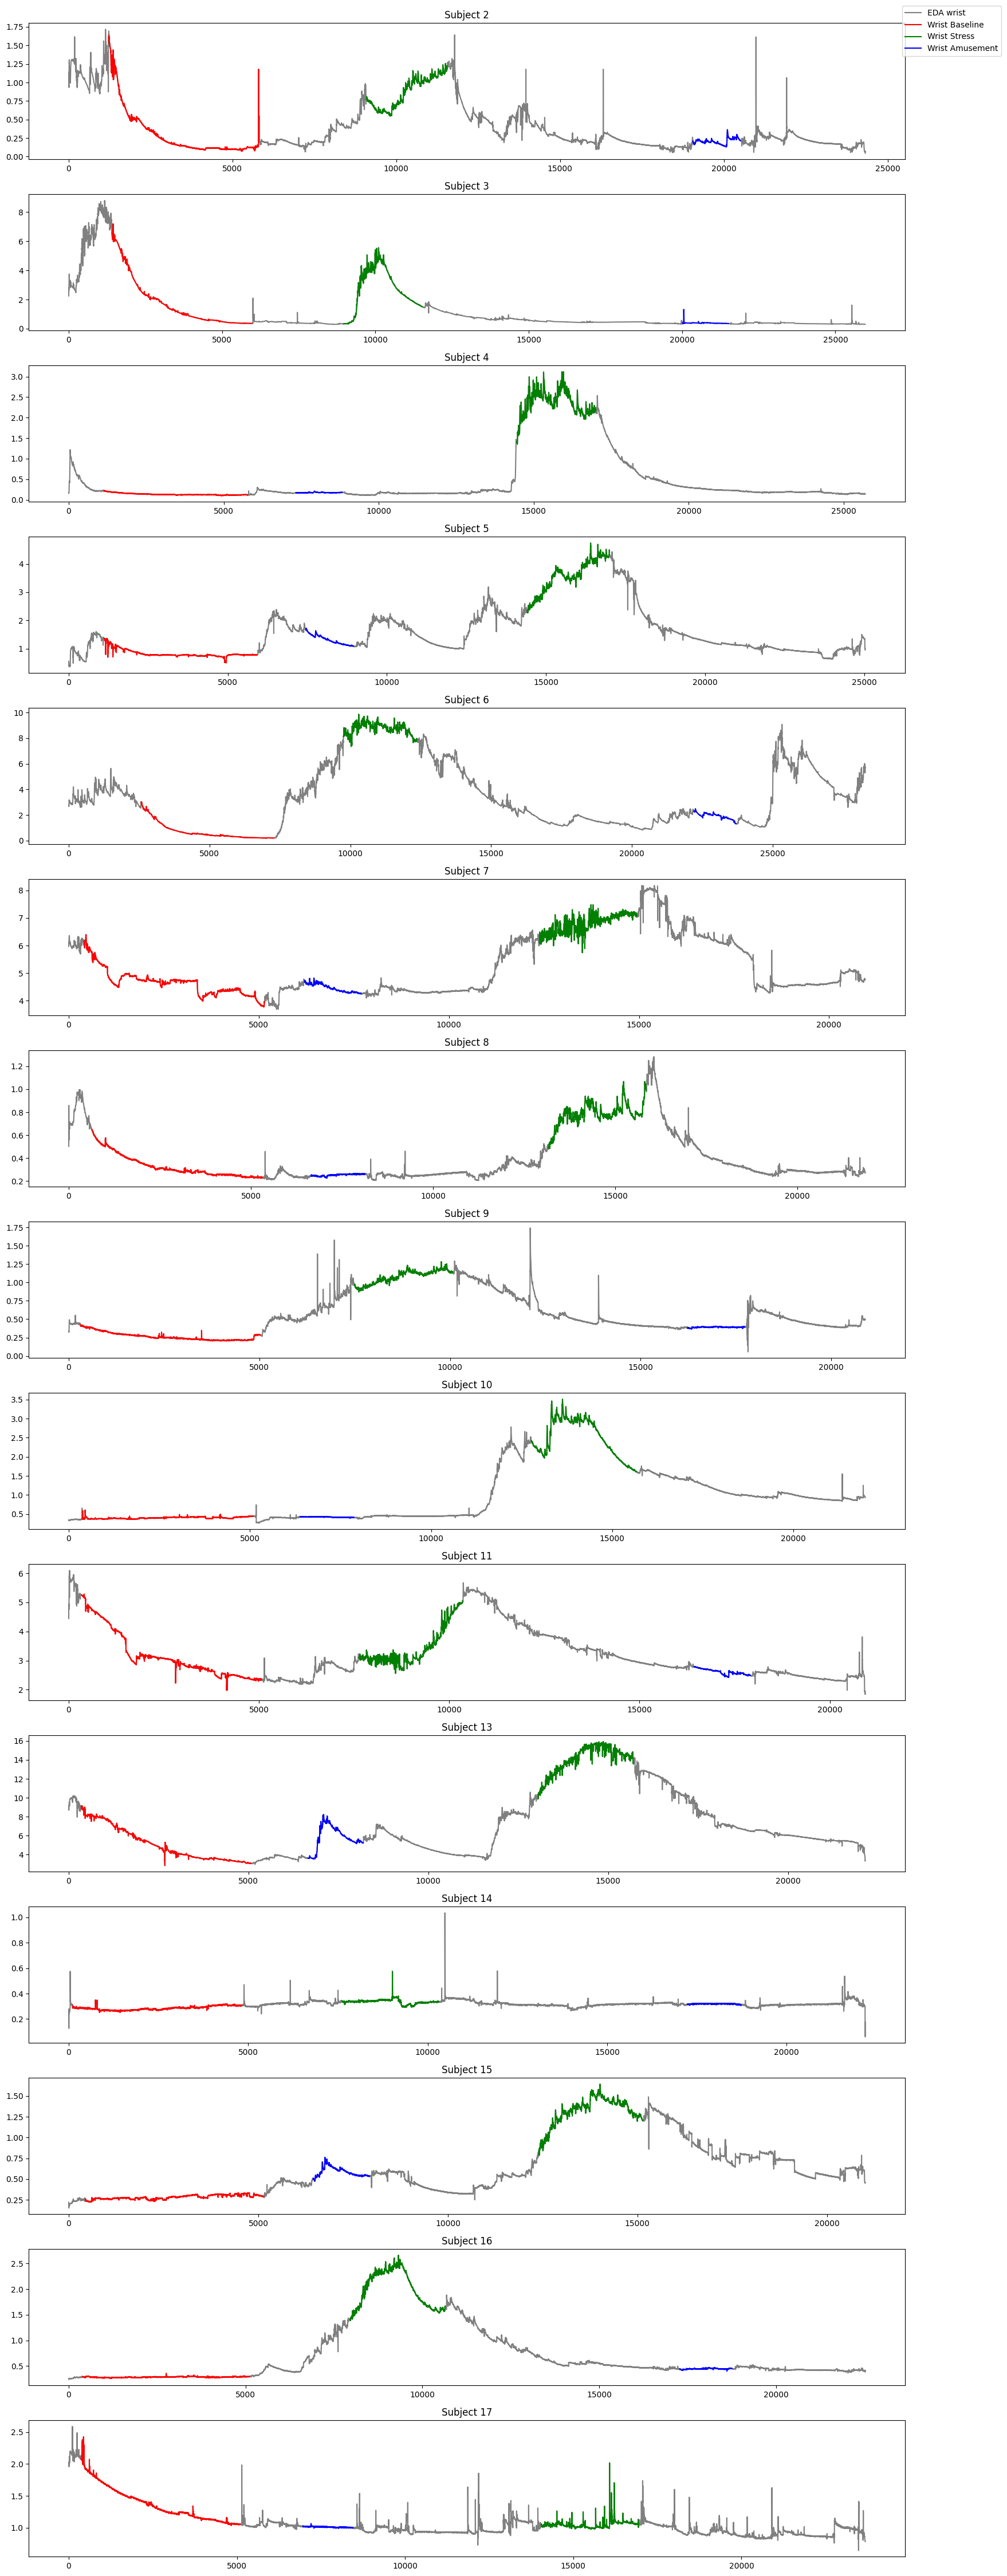

In [19]:
import matplotlib.pyplot as plt
import numpy as np

colors = {1: 'red', 2: 'green', 3: 'blue'}
estado_labels = {1: "Baseline", 2: "Stress", 3: "Amusement"}

fig, axes = plt.subplots(len(subjects), 1, figsize=(16, 3 * len(subjects)))

factor = 175

for idx, current_subject in enumerate(subjects):
    if current_subject.get_subject_number() in (2,3,4,5,6,7,8,9,10,11,13,14,15,16,17):
        wrist_data = current_subject.get_wrist_data()
        chest_data = current_subject.get_chest_data()
        label_data = current_subject.get_label_data()
        
        label_data_decimated = label_data[::factor]
        
        print(f'Subject {current_subject.get_subject_number()}')
        print(f'Labels \t{len(label_data_decimated)}')

        for item in wrist_data:
            if item == "EDA":
                eda_data_wrist = wrist_data[item]
                eda_data_chest = chest_data["EDA"]

                eda_data_wrist_1d = eda_data_wrist.flatten()
                eda_data_chest_1d = eda_data_chest.flatten()

                min_length = min(len(eda_data_wrist_1d), len(label_data_decimated))
                eda_data_wrist_1d = eda_data_wrist_1d[:min_length]
                eda_data_chest_1d = eda_data_chest_1d[:min_length]
                label_data_decimated = label_data_decimated[:min_length]

                axes[idx].plot(eda_data_wrist_1d, label="EDA wrist", color='gray')
                #axes[idx].plot(eda_data_chest_1d, label="EDA chest", color='black')

                for label in [1, 2, 3]:
                    estado_label = estado_labels[label]
                    mask_eda = (label_data_decimated == label)
                    axes[idx].plot(np.where(mask_eda, eda_data_wrist_1d, np.nan), label=f"Wrist {estado_label}", color=colors[label])
                    #axes[idx].plot(np.where(mask_eda, eda_data_chest_1d, np.nan), label=f"Chest {estado_label}", color=colors[label], linestyle='dashed')

        axes[idx].set_title(f"Subject {current_subject.get_subject_number()}")

handles, labels = axes[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()


### Tecnica de Decimación

In [98]:

def wrapper_real(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects) ):
            wrist_data = current_subject.get_wrist_data()
            label_data = current_subject.get_label_data()

        for item in wrist_data:
            if(item == "BVP"):
                pass
                #print("ESTO ES BVP")
                #print(wrist_data[item].shape)
            if(item == "EDA"):
                eda_data = wrist_data[item]
                #print("ESTO ES EDA")
                #print(wrist_data[item].shape)
                decimation_factor = int(700 / 4)
                label_data_decimated = label_data[::decimation_factor]

                min_length = min(len(label_data_decimated), len(eda_data.flatten()))
                label_data_decimated = label_data_decimated[:min_length]
                eda_data_1d = eda_data.flatten()[:min_length]

                dicc = {
                    'TIME': np.arange(min_length),
                    'SUBJECT': [current_subject.get_subject_number()] * min_length,
                    'EDA_WRIST': eda_data_1d,
                    'STATE': label_data_decimated
                }
                current_data_wrist = pd.DataFrame(dicc, columns=['TIME', 'SUBJECT', 'EDA_WRIST', 'STATE'])
                
                condition = current_data_wrist['STATE'].isin([1, 2, 3])
                filtered_data = current_data_wrist[condition].copy()
                #filtered_data['EDA_LOW_PASS_FILTER'] = butter_lowpass_filter(filtered_data['EDA_WRIST'].values, 1.0, 4, 6)
                all_data_wrist.append(filtered_data)   
    all_data = pd.concat(all_data_wrist)
    return all_data

In [99]:
data_subjects = wrapper_real(subjects)
data_subjects

,TIME,SUBJECT,EDA_WRIST,STATE
1227,1227,2,1.640539,1
1228,1228,2,1.634132,1
1229,1229,2,1.614912,1
1230,1230,2,1.591848,1
1231,1231,2,1.558534,1
...,...,...,...,...
16936,16936,17,1.018841,2
16937,16937,17,1.004767,2
16938,16938,17,1.008606,2
16939,16939,17,1.046988,2


## Wraper real BVP add


In [7]:
def wrapper_real_v2(subjects):
    all_data_wrist = []
    
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects)):
            wrist_data = current_subject.get_wrist_data()
            label_data = current_subject.get_label_data()

            eda_data = wrist_data["EDA"]
            bvp_data = wrist_data["BVP"]

            # Decimación de las etiquetas para coincidir con BVP (64 Hz)
            decimation_factor = int(700 / 64)
            label_data_decimated = label_data[::decimation_factor]
            
            # Resampleo del EDA a 64 Hz (usando interpolación lineal)
            eda_resampled = pd.Series(eda_data.flatten()).interpolate(method='linear', limit_direction='both').values
            eda_resampled = eda_resampled[::16]  # Tomando cada 16º punto para llegar a 64Hz

            min_length = min(len(label_data_decimated), len(bvp_data.flatten()), len(eda_resampled))

            # Crear DataFrame con todas las señales sincronizadas
            dicc = {
                'TIME': np.arange(min_length),
                'SUBJECT': [current_subject.get_subject_number()] * min_length,
                'EDA_WRIST': eda_resampled[:min_length],
                'BVP': bvp_data.flatten()[:min_length],
                'STATE': label_data_decimated[:min_length]
            }
            
            current_data_wrist = pd.DataFrame(dicc, columns=['TIME', 'SUBJECT', 'EDA_WRIST', 'BVP', 'STATE'])

            # Filtrar por condiciones y agregar al conjunto de datos final
            condition = current_data_wrist['STATE'].isin([1, 2, 3])
            filtered_data = current_data_wrist[condition].copy()
            #filtered_data['EDA_LOW_PASS_FILTER'] = butter_lowpass_filter(filtered_data['EDA_WRIST'].values, 1.0, 64, 6)
            # Si quieres fÇiltrar BVP, puedes agregar esa lógica aquí.
            
            all_data_wrist.append(filtered_data)

    all_data = pd.concat(all_data_wrist)
    return all_data

In [60]:
data_subjects = wrapper_real_v2(subjects)
data_subjects

,TIME,SUBJECT,EDA_WRIST,BVP,STATE


### All signals dow-sampling to 64 hz and matching labels
| Signal | Base Frecuency  | Method |  Target Frecuency |
|--------------|--------------|--------------|--------------|
| EDA    | 4hz    | UpSampling   | 64hz    |
| TEMP   | 4hz    | Equal        | 64hz    |
| BVP    | 64hz   | DownSampling | 64hz    |
| LABELS | 700hz  | Decimation   | 64hz    |

In [15]:
def wrapper_real_v3_64hz(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects)):
            wrist_data = current_subject.get_wrist_data()
            label_data = current_subject.get_label_data()

        for item in wrist_data:
            if item == "EDA":
                eda_data = wrist_data[item]
                # Asegurarse de que eda_data sea un array unidimensional
                eda_data = np.squeeze(eda_data)
                
                # Interpolación para EDA de 4 Hz a 64 Hz
                interpolated_times = np.linspace(0, len(eda_data) - 1, len(eda_data) * 16)
                eda_interpolated = np.interp(interpolated_times, np.arange(len(eda_data)), eda_data)
                
                # Downsampling para etiquetas de 700 Hz a 64 Hz
                decimation_factor = int(700 / 64)
                label_data_decimated = label_data[::decimation_factor]
                # Asegurarse de que label_data_decimated sea un array unidimensional
                label_data_decimated = np.squeeze(label_data_decimated)
                
                # Obtener BVP y asegurarse de que sea un array unidimensional
                bvp_data = wrist_data["BVP"]
                bvp_data = np.squeeze(bvp_data)
                
                # Interpolación para TEMP de 4 Hz a 64 Hz
                temp_data = wrist_data["TEMP"]
                temp_data = np.squeeze(temp_data)
                interpolated_times_temp = np.linspace(0, len(temp_data) - 1, len(temp_data) * 16)
                temp_interpolated = np.interp(interpolated_times_temp, np.arange(len(temp_data)), temp_data)

                # Asegurarse de que las longitudes sean consistentes
                min_length = min(len(label_data_decimated), len(eda_interpolated), len(bvp_data), len(temp_interpolated))
                label_data_decimated = label_data_decimated[:min_length]
                eda_data_1d = eda_interpolated[:min_length]
                bvp_data_1d = bvp_data[:min_length]
                temp_data_1d = temp_interpolated[:min_length]

                dicc = {
                    'TIME': np.arange(min_length),
                    'SUBJECT': [current_subject.get_subject_number()] * min_length,
                    'EDA_WRIST': np.round(eda_data_1d,3),
                    'BVP_WRIST': np.round(bvp_data_1d,3),
                    'TEMP_WRIST': np.round(temp_data_1d,3),
                    'STATE': label_data_decimated
                }
                current_data_wrist = pd.DataFrame(dicc, columns=['TIME', 'SUBJECT', 'EDA_WRIST', 'BVP_WRIST', 'TEMP_WRIST', 'STATE'])
                
                condition = current_data_wrist['STATE'].isin([1, 2, 3])
                filtered_data = current_data_wrist[condition].copy()
                all_data_wrist.append(filtered_data)   

    all_data = pd.concat(all_data_wrist)
    return all_data


In [16]:
data_subjects_64hz = wrapper_real_v3_64hz(subjects)
data_subjects_64hz

,TIME,SUBJECT,EDA_WRIST,BVP_WRIST,TEMP_WRIST,STATE
21459,21459,2,1.253,-47.98,35.830,1
21460,21460,2,1.252,-113.26,35.830,1
21461,21461,2,1.250,-157.08,35.830,1
21462,21462,2,1.249,-183.70,35.830,1
21463,21463,2,1.248,-202.20,35.830,1
...,...,...,...,...,...,...
296462,296462,17,0.930,12.27,32.964,2
296463,296463,17,0.930,12.22,32.962,2
296464,296464,17,0.930,12.41,32.959,2
296465,296465,17,0.930,12.68,32.957,2


### All signals dow-sampling to 4 hz and matching labels
| Signal | Base Frecuency  | Method |  Target Frecuency |
|--------------|--------------|--------------|--------------|
| EDA    | 4hz    | UpSampling   | 4hz    |
| TEMP   | 4hz    | Equal        | 4hz    |
| BVP    | 64hz   | DownSampling | 4hz    |
| LABELS | 700hz  | Decimation   | 4hz    |

In [17]:
def wrapper_real_v3_4hz(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects)):
            wrist_data = current_subject.get_wrist_data()
            label_data = current_subject.get_label_data()

            eda_data = np.squeeze(wrist_data["EDA"])
            temp_data = np.squeeze(wrist_data["TEMP"])

            # Downsampling para BVP de 64 Hz a 4 Hz
            decimation_factor_bvp = int(64 / 4)
            bvp_data = np.squeeze(wrist_data["BVP"])
            bvp_data_downsampled = bvp_data[::decimation_factor_bvp]

            # Downsampling para etiquetas de 700 Hz a 4 Hz
            decimation_factor_labels = int(700 / 4)
            label_data_decimated = label_data[::decimation_factor_labels]
            label_data_decimated = np.squeeze(label_data_decimated)

            # Asegurarse de que todas las longitudes sean consistentes
            min_length = min(len(label_data_decimated), len(eda_data), len(bvp_data_downsampled), len(temp_data))
            label_data_decimated = label_data_decimated[:min_length]
            eda_data_1d = eda_data[:min_length]
            bvp_data_1d = bvp_data_downsampled[:min_length]
            temp_data_1d = temp_data[:min_length]

            dicc = {
                'TIME': np.arange(min_length),
                'SUBJECT': [current_subject.get_subject_number()] * min_length,
                'EDA_WRIST': np.round(eda_data_1d, 3),
                'BVP_WRIST': np.round(bvp_data_1d, 3),
                'TEMP_WRIST': np.round(temp_data_1d, 3),
                'STATE': label_data_decimated
            }
            current_data_wrist = pd.DataFrame(dicc, columns=['TIME', 'SUBJECT', 'EDA_WRIST', 'BVP_WRIST', 'TEMP_WRIST', 'STATE'])
            
            condition = current_data_wrist['STATE'].isin([1, 2, 3])
            filtered_data = current_data_wrist[condition].copy()
            all_data_wrist.append(filtered_data)

    all_data = pd.concat(all_data_wrist)
    return all_data


In [37]:
import pandas as pd
import numpy as np

def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def wrapper_real_v3_4hz_all_normalized(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects)):
            wrist_data = current_subject.get_wrist_data()
            label_data = current_subject.get_label_data()

            eda_data = np.squeeze(wrist_data["EDA"])
            temp_data = np.squeeze(wrist_data["TEMP"])

            # Downsampling para BVP de 64 Hz a 4 Hz
            decimation_factor_bvp = int(64 / 4)
            bvp_data = np.squeeze(wrist_data["BVP"])
            bvp_data_downsampled = bvp_data[::decimation_factor_bvp]

            # Downsampling para etiquetas de 700 Hz a 4 Hz
            decimation_factor_labels = int(700 / 4)
            label_data_decimated = label_data[::decimation_factor_labels]
            label_data_decimated = np.squeeze(label_data_decimated)

            min_length = min(len(label_data_decimated), len(eda_data), len(bvp_data_downsampled), len(temp_data))
            label_data_decimated = label_data_decimated[:min_length]
            eda_data_1d = eda_data[:min_length]
            bvp_data_1d = bvp_data_downsampled[:min_length]
            temp_data_1d = temp_data[:min_length]

            dicc = {
                'TIME': np.arange(min_length),
                'SUBJECT': [current_subject.get_subject_number()] * min_length,
                'EDA_WRIST': eda_data_1d,
                'BVP_WRIST': bvp_data_1d,
                'TEMP_WRIST': temp_data_1d,
                'STATE': label_data_decimated
            }
            current_data_wrist = pd.DataFrame(dicc, columns=['TIME', 'SUBJECT', 'EDA_WRIST', 'BVP_WRIST', 'TEMP_WRIST', 'STATE'])
            
            condition = current_data_wrist['STATE'].isin([1, 2, 3])
            filtered_data = current_data_wrist[condition].copy()
            all_data_wrist.append(filtered_data)

    all_data = pd.concat(all_data_wrist)

    # Aplicar normalización Min-Max
    all_data[['EDA_WRIST', 'BVP_WRIST', 'TEMP_WRIST']] = all_data[['EDA_WRIST', 'BVP_WRIST', 'TEMP_WRIST']].apply(min_max_normalize)

    return all_data


In [38]:
data_subjects_4hz_normalized = wrapper_real_v3_4hz_all_normalized(subjects)
data_subjects_4hz_normalized

,TIME,SUBJECT,EDA_WRIST,BVP_WRIST,TEMP_WRIST,STATE
1227,1227,2,0.098818,0.520054,0.975904,1
1228,1228,2,0.098414,0.541366,0.975904,1
1229,1229,2,0.097201,0.548687,0.975904,1
1230,1230,2,0.095745,0.562575,0.975904,1
1231,1231,2,0.093643,0.518298,0.975904,1
...,...,...,...,...,...,...
16936,16936,17,0.059586,0.512154,0.501506,2
16937,16937,17,0.058698,0.535055,0.501506,2
16938,16938,17,0.058940,0.511097,0.501506,2
16939,16939,17,0.061362,0.530085,0.501506,2


## Wraper real in construction

In [32]:
from syncing.model import dsp
import pandas as pd
import numpy as np

def wrapper_real_v2(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects)):
            wrist_data = current_subject.get_wrist_data()
            label_data = current_subject.get_label_data()
            eda_data = wrist_data["EDA"]
            bvp_data = wrist_data["BVP"]

            data_sets = {
                'ref': {'time': np.arange(len(label_data)), 'STATE': label_data},
                'eda': {'time': np.arange(len(eda_data)), 'STATE': eda_data.flatten()},
                'bvp': {'time': np.arange(len(bvp_data)), 'STATE': bvp_data.flatten()}
            }

            sol = dsp(dict(
                data=data_sets, x_label='time', y_label='STATE',
                reference_name='ref', interpolation_method='cubic'
            ))
            eda_synced = sol['resampled']['eda']['STATE']
            bvp_synced = sol['resampled']['bvp']['STATE']

            dicc = {
                'TIME': np.arange(len(label_data)),
                'SUBJECT': [current_subject.get_subject_number()] * len(label_data),
                'EDA_WRIST': eda_synced, 
                'BVP_WRIST': bvp_synced,
                'STATE': label_data # etiqueta
            }

            current_data_wrist = pd.DataFrame(dicc, columns=['TIME', 'SUBJECT', 'EDA_WRIST', 'BVP_WRIST', 'STATE'])

            condition = current_data_wrist['STATE'].isin([1, 2, 3])
            filtered_data = current_data_wrist[condition].copy()
            #filtered_data['EDA_LOW_PASS_FILTER'] = butter_lowpass_filter(filtered_data['EDA_WRIST'].values, 1.0, 4, 6)
            all_data_wrist.append(filtered_data)   

    all_data = pd.concat(all_data_wrist)
    return all_data

In [41]:
data_subjects.head(10000)

,TIME,SUBJECT,EDA_WRIST,BVP_WRIST,STATE
214583,214583,2,0.045113,19.71,1
214584,214584,2,0.045113,19.71,1
214585,214585,2,0.045113,19.71,1
214586,214586,2,0.045113,19.71,1
214587,214587,2,0.045113,19.71,1
...,...,...,...,...,...
224578,224578,2,0.045113,19.71,1
224579,224579,2,0.045113,19.71,1
224580,224580,2,0.045113,19.71,1
224581,224581,2,0.045113,19.71,1


In [21]:
import numpy as np
data_sets = {}
time = np.arange(0, 150, .1)
velocity = (1 + np.sin(time / 10)) * 60
data_sets['ref'] = dict(
time=time,                                               # [10 Hz]
velocity=velocity / 3.6                                  # [m/s]
)
data_sets['obd'] = dict(
time=time[::10] + 12,                                    # 1 Hz
velocity=velocity[::10] + np.random.normal(0, 5, 150),   # [km/h]
engine_rpm=np.maximum(
np.random.normal(velocity[::10] * 3 + 600, 5), 800
)                                                        # [RPM]
)
data_sets['dyno'] = dict(
time=time + 6.66,                                        # 10 Hz
velocity=velocity + np.random.normal(0, 1, 1500)         # [km/h]
)

from syncing.model import dsp
sol = dsp(dict(
data=data_sets, x_label='time', y_label='velocity',
reference_name='ref', interpolation_method='cubic'
))

sol

Solution([('data',
           {'ref': {'time': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.497e+02, 1.498e+02,
                    1.499e+02]),
             'velocity': array([16.66666667, 16.83333056, 16.99997778, ..., 27.87970753,
                    27.7558422 , 27.63086798])},
            'obd': {'time': array([ 12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
                     23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
                     34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
                     45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
                     56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
                     67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
                     78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
                     89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
            

In [9]:
for i,j in sol.items():
    print(i)

data
interpolation_method
no_sync
reference_name
x_label
y_label
labels
shifts
methods
resampled


In [29]:
for i,j in sol['resampled'].items():
    print(i,j)
    for k,l in j.items():
        print(k,l)

time 1500
velocity 1500
velocity 1500
engine_rpm 1500
velocity 1500


In [20]:
for i,j in sol['data'].items():
    for j in j:
        print(j)

time
velocity
time
velocity
engine_rpm
time
velocity


### Agregación de data

In [8]:
# ID_subjects = [1,2,3,...17]

def wrapper(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects) ):
            wrist_data = current_subject.get_wrist_data()
            chest_data = current_subject.get_chest_data()
            label_data = current_subject.get_label_data()

            print(f'Subject {current_subject.get_subject_number()}')
            print(f'Labels \t{len(label_data)}')
        
            for item in wrist_data:
                if(item == "EDA"):
                    eda_data = wrist_data[item]

                    eda_data_1d = eda_data.flatten()
                    interpolated_eda_data = np.interp(
                        np.linspace(0, len(eda_data_1d) - 1, len(label_data)),
                        np.arange(len(eda_data_1d)),
                        eda_data_1d
                    )

                    label_complete = [current_subject.get_subject_number()]*len(interpolated_eda_data)
                    #print(interpolated_eda_data)
                    #print(len(window_complete))
                    #print(type(interpolated_eda_data)
                    dicc = {
                        'TIME': np.arange(len(interpolated_eda_data)),
                        'SUBJECT': label_complete,
                        'EDA_WRIST': interpolated_eda_data,
                        'STATE': label_data
                    }
                    current_data_wrist = pd.DataFrame(dicc,columns=['TIME','SUBJECT','EDA_WRIST','STATE'])
                    condition = current_data_wrist['STATE'].isin([1, 2])
                    filtered_data = current_data_wrist[condition].copy()
                    filtered_data['EDA_LOW_PASS_FILTER'] = butter_lowpass_filter(filtered_data['EDA_WRIST'].values, 1.0, 4, 6)
                    #signals,info = eda_custom_process(filtered_data['EDA_LOW_PASS_FILTER'].values)
                    eda_signal = nk.signal_sanitize(filtered_data['EDA_LOW_PASS_FILTER'].values)
                    eda_cleaned = eda_signal  #Add your custom cleaning module here or skip cleaning
                    decomposed = nk.eda_phasic(eda_cleaned, sampling_rate=4)
                    #print(filtered_data.shape)
                    #signals, info = nk.eda_process(filtered_data['EDA_LOW_PASS_FILTER'], sampling_rate=4)
                    #print(signals.shape)
                    #nk.eda_plot(signals, sampling_rate=4)
                    filtered_data = pd.concat([filtered_data,decomposed], axis=1)  # Añadiendo el DataFrame signals
                    all_data_wrist.append(filtered_data)
        all_data = pd.concat(all_data_wrist)
    return all_data


In [25]:
# ID_subjects = [1,2,3,...17]

def wrapper(subjects):
    all_data_wrist = []
    for current_subject in subjects:
        if(current_subject.get_subject_number() in tuple(ID_subjects) ):
            wrist_data = current_subject.get_wrist_data()
            chest_data = current_subject.get_chest_data()
            label_data = current_subject.get_label_data()

            print(f'Subject {current_subject.get_subject_number()}')
            print(f'Labels \t{len(label_data)}')

            for item in wrist_data:
                if(item == "EDA"):
                    eda_data = wrist_data[item]

                    eda_data_1d = eda_data.flatten()
                    interpolated_eda_data = np.interp(
                        np.linspace(0, len(eda_data_1d) - 1, len(label_data)),
                        np.arange(len(eda_data_1d)),
                        eda_data_1d
                    )

                    label_complete = [current_subject.get_subject_number()]*len(interpolated_eda_data)
                    #print(interpolated_eda_data)
                    #print(len(window_complete))
                    #print(type(interpolated_eda_data)
                    dicc = {
                        'TIME': np.arange(len(interpolated_eda_data)),
                        'SUBJECT': label_complete,
                        'EDA_WRIST': interpolated_eda_data,
                        'STATE': label_data
                    }
                    
                    current_data_wrist = pd.DataFrame(dicc,columns=['TIME','SUBJECT','EDA_WRIST','STATE'])
                    condition = current_data_wrist['STATE'].isin([1, 2])
                    filtered_data = current_data_wrist[condition].copy()
                    filtered_data['EDA_LOW_PASS_FILTER'] = butter_lowpass_filter(filtered_data['EDA_WRIST'].values, 1.0, 4, 6)
                    all_data_wrist.append(filtered_data)
        all_data = pd.concat(all_data_wrist)
    return all_data



In [88]:
ID_subjects = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]

data_subjects = wrapper_real(subjects)
results = []
window_size = 2800
overlap = int(window_size/2)

In [10]:
subject_cleaned = data_subjects.dropna()
subject_cleaned['TIME'] = subject_cleaned['TIME'].astype(int)
subject_cleaned['SUBJECT'] = subject_cleaned['SUBJECT'].astype(int)
subject_cleaned['STATE'] = subject_cleaned['STATE'].astype(int)

/var/folders/8r/343rrfbs0gz7zy6149nd6hx40000gn/T/ipykernel_3449/1596530675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_cleaned['TIME'] = subject_cleaned['TIME'].astype(int)
/var/folders/8r/343rrfbs0gz7zy6149nd6hx40000gn/T/ipykernel_3449/1596530675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_cleaned['SUBJECT'] = subject_cleaned['SUBJECT'].astype(int)
/var/folders/8r/343rrfbs0gz7zy6149nd6hx40000gn/T/ipykernel_3449/1596530675.py:4: SettingWithCopyWarning: 
A value is trying to b

### Extrayendo la señal limpia y fásica

#### Señal Limpia

In [21]:
def eda_custom_process_clean(eda_signal, sampling_rate=4):
    return np.around(butter_lowpass_filter(eda_signal, 1.0, sampling_rate, 6), 6).tolist()

#### Señal fásica luego de pasar por el butter_low_pass_filter

In [22]:
def eda_custom_process_phasic(eda_signal, sampling_rate=4):
    eda_signal = butter_lowpass_filter(eda_signal, 1.0, sampling_rate, 6)
    if type(eda_signal) is pd.Series and type(eda_signal.index) != pd.RangeIndex:
        eda_signal = eda_signal.reset_index(drop=True)
    eda_decomposed = nk.eda_phasic(eda_signal, sampling_rate=sampling_rate)
    return np.around(eda_decomposed['EDA_Phasic'],6).values.tolist()

#### Ambas funciones

In [23]:
def eda_custom_process_phasic_signal(eda_signal, sampling_rate=4):
    eda_signal = butter_lowpass_filter(eda_signal, 1.0, 4, 6)
    #eda_signal = nk.signal_sanitize(eda_signal)
    if type(eda_signal) is pd.Series and type(eda_signal.index) != pd.RangeIndex:
        eda_signal = eda_signal.reset_index(drop=True)
    eda_decomposed = nk.eda_phasic(eda_signal, sampling_rate=sampling_rate)
    return eda_signal

In [157]:
def process_windowing_data(data, window_size, overlap, flag_eda_wrist_as_series=False,flag_eda_wrist_add_mean=False):
    """
    Esta función procesa un DataFrame de pandas aplicando una ventana deslizante y calculando varias estadísticas dentro de cada ventana.

    Parámetros:
    - data        (pd.DataFrame): El DataFrame de pandas a procesar.
    - window_size (int): El tamaño de la ventana deslizante.
    - overlap     (float): La fracción de superposición entre ventanas consecutivas (debe estar entre 0 y 1).
    - flag_eda_wrist_as_series (bool) : Para que la columna EDA_WRIST sea una serie de numpy o una lista de numpy arrays
    - flag_eda_wrist_add_mean (bool) : Para que la columna MEAN_EDA_WRIST sea añadida al dataframe o no
    
    Retorna:
    - results_df  (pd.DataFrame): Un DataFrame de pandas que contiene las señales calculadas para cada ventana.
    """

    if not (0 <= overlap <= 1):
        raise ValueError("El overlap debe estar entre 0 y 1.")

    window_numbers = {}
    results        = []

    step_size      = int(window_size * (1 - overlap))
    
    for i in range(0, len(data) - window_size + 1, step_size):
        window           = data.iloc[i:i+window_size]
        time             = [window['TIME'].values[0], window['TIME'].values[-1]]
        mode_subject     = window['SUBJECT'].mode().values[0]
        mode_state       = window['STATE'].mode().values[0]
        eda_wrist        = window['EDA_WRIST'].values.tolist()
        #print(type(eda_wrist))
        #print(type(eda_custom_process_clean(window['EDA_WRIST'])))
        #print(type(eda_custom_process_phasic(window['EDA_WRIST'])))
        eda_wrist_clean  = eda_custom_process_clean(window['EDA_WRIST'])
        eda_wrist_phasic = eda_custom_process_phasic(window['EDA_WRIST'])
        # EDA_LOW_PASS_FILTER	EDA_Tonic	EDA_Phasic
        
        if mode_subject not in window_numbers:
            window_numbers[mode_subject] = 1  # El primer número de ventana es 1
        else:
            window_numbers[mode_subject] += 1

        window_number = window_numbers[mode_subject]

        results.append({'TIME': time,'WINDOW_NUMBER': window_number, 'SUBJECT': mode_subject, 'EDA_WRIST': eda_wrist,'CLEAN_EDA_WRIST':eda_wrist_clean,'PHASIC_EDA_WRIST': eda_wrist_phasic, 'STATE': mode_state})
        

    oppenheimer_result = pd.DataFrame(results)

    if(not flag_eda_wrist_as_series):
        oppenheimer_result['EDA_WRIST']        = oppenheimer_result['EDA_WRIST']             # Esto podría cambiar porque si necesitamos los indices lo comentamos pero solo para extraer la lista tal cual
        oppenheimer_result['CLEAN_EDA_WRIST']  = oppenheimer_result['CLEAN_EDA_WRIST']       # Esto podría cambiar porque si necesitamos los indices lo comentamos pero solo para extraer la lista tal cual
        oppenheimer_result['PHASIC_EDA_WRIST'] = oppenheimer_result['PHASIC_EDA_WRIST']      # Esto podría cambiar porque si necesitamos los indices lo comentamos pero solo para extraer la lista tal cual
    if(not flag_eda_wrist_add_mean):
        oppenheimer_result['MEAN_EDA_WRIST']   = oppenheimer_result['EDA_WRIST'].apply(np.mean)
        MEAN_EDA_WRIST                         = oppenheimer_result.pop('MEAN_EDA_WRIST')
        insert_position                        = len(oppenheimer_result.columns) - 1
        oppenheimer_result.insert(insert_position, 'MEAN_EDA_WRIST', MEAN_EDA_WRIST)
    return oppenheimer_result

data_eda_wrist_process = process_windowing_data(data_subjects,120,0.5)

In [28]:
def process_windowing_data_v3(data, window_size, overlap, flag_eda_wrist_as_series=False, flag_eda_wrist_add_mean=False):
    """
    Esta función procesa un DataFrame de pandas aplicando una ventana deslizante y calculando varias estadísticas dentro de cada ventana.

    Parámetros:
    - data        (pd.DataFrame): El DataFrame de pandas a procesar.
    - window_size (int): El tamaño de la ventana deslizante.
    - overlap     (float): La fracción de superposición entre ventanas consecutivas (debe estar entre 0 y 1).
    - flag_eda_wrist_as_series (bool) : Para que la columna EDA_WRIST sea una serie de numpy o una lista de numpy arrays
    - flag_eda_wrist_add_mean (bool) : Para que la columna MEAN_EDA_WRIST sea añadida al dataframe o no
    
    Retorna:
    - results_df  (pd.DataFrame): Un DataFrame de pandas que contiene las señales calculadas para cada ventana.
    """

    if not (0 <= overlap <= 1):
        raise ValueError("El overlap debe estar entre 0 y 1.")

    window_numbers = {}
    results        = []

    step_size      = int(window_size * (1 - overlap))
    
    for i in range(0, len(data) - window_size + 1, step_size):
        window           = data.iloc[i:i+window_size]
        time             = [window['TIME'].values[0], window['TIME'].values[-1]]
        mode_subject     = window['SUBJECT'].mode().values[0]
        mode_state       = window['STATE'].mode().values[0]
        eda_wrist        = window['EDA_WRIST'].values.tolist()
        eda_wrist_clean  = eda_custom_process_clean(window['EDA_WRIST'])
        eda_wrist_phasic = eda_custom_process_phasic(window['EDA_WRIST'])
        
        # Extrayendo las señales TEMP_WRIST y BVP_WRIST
        temp_wrist       = window['TEMP_WRIST'].values.tolist()
        bvp_wrist        = window['BVP_WRIST'].values.tolist()

        if mode_subject not in window_numbers:
            window_numbers[mode_subject] = 1  # El primer número de ventana es 1
        else:
            window_numbers[mode_subject] += 1

        window_number = window_numbers[mode_subject]

        results.append({
            'TIME': time,
            'WINDOW_NUMBER': window_number, 
            'SUBJECT': mode_subject, 
            'EDA_WRIST': eda_wrist,
            'CLEAN_EDA_WRIST': eda_wrist_clean,
            'PHASIC_EDA_WRIST': eda_wrist_phasic, 
            'TEMP_WRIST': temp_wrist,   
            'BVP_WRIST': bvp_wrist,     
            'STATE': mode_state
        })
        
    oppenheimer_result = pd.DataFrame(results)

    if not flag_eda_wrist_as_series:
        oppenheimer_result['EDA_WRIST']        = oppenheimer_result['EDA_WRIST']
        oppenheimer_result['CLEAN_EDA_WRIST']  = oppenheimer_result['CLEAN_EDA_WRIST']
        oppenheimer_result['PHASIC_EDA_WRIST'] = oppenheimer_result['PHASIC_EDA_WRIST']
    
    if not flag_eda_wrist_add_mean:
        oppenheimer_result['MEAN_EDA_WRIST']   = oppenheimer_result['EDA_WRIST'].apply(np.mean)
        MEAN_EDA_WRIST                         = oppenheimer_result.pop('MEAN_EDA_WRIST')
        insert_position                        = len(oppenheimer_result.columns) - 1
        oppenheimer_result.insert(insert_position, 'MEAN_EDA_WRIST', MEAN_EDA_WRIST)

    return oppenheimer_result


In [14]:
data_eda_wrist_process_v3 = process_windowing_data_v3(data_subjects,window_size=1024, overlap=0.5)

In [151]:
data_eda_wrist_process_v3.to_csv("../data/data_windowed_sync/16s_50o.csv")

In [158]:
data_eda_wrist_process

,TIME,WINDOW_NUMBER,SUBJECT,EDA_WRIST,CLEAN_EDA_WRIST,PHASIC_EDA_WRIST,MEAN_EDA_WRIST,STATE
0,"[1227, 1346]",1,2,"[1.640539, 1.634132, 1.614912, 1.591848, 1.558...","[0.048541, 0.339595, 1.028248, 1.765771, 1.935...","[0.007628, 0.215021, 0.820546, 1.475903, 1.564...",1.375709,1
1,"[1287, 1406]",2,2,"[1.390679, 1.366334, 1.341989, 1.320206, 1.280...","[0.041148, 0.287314, 0.867487, 1.483228, 1.614...","[-0.004412, 0.174939, 0.688628, 1.238561, 1.30...",1.240336,1
2,"[1347, 1466]",3,2,"[1.259984, 1.28561, 1.276641, 1.186948, 1.3740...","[0.037281, 0.261723, 0.796224, 1.374417, 1.514...","[0.081379, 0.235548, 0.700365, 1.20981, 1.2823...",1.199035,1
3,"[1407, 1526]",4,2,"[1.233075, 1.229232, 1.224106, 1.220262, 1.221...","[0.036484, 0.255278, 0.773338, 1.330143, 1.465...","[0.003223, 0.159538, 0.615418, 1.110663, 1.185...",1.096801,1
4,"[1467, 1586]",5,2,"[1.122881, 1.117756, 1.120318, 1.115193, 1.111...","[0.033224, 0.232417, 0.704105, 1.211704, 1.336...","[0.006717, 0.147803, 0.561779, 1.012362, 1.081...",0.940365,1
...,...,...,...,...,...,...,...,...
2204,"[16573, 16692]",147,17,"[1.086649, 1.08537, 1.082811, 1.082811, 1.0866...","[0.032152, 0.225026, 0.681999, 1.17402, 1.2954...","[0.000911, 0.135512, 0.534518, 0.969168, 1.034...",1.082310,2
2205,"[16633, 16752]",148,17,"[1.082811, 1.081532, 1.082811, 1.081532, 1.081...","[0.032038, 0.224231, 0.679703, 1.170626, 1.292...","[0.003129, 0.137313, 0.535085, 0.968911, 1.034...",1.077587,2
2206,"[16693, 16812]",149,17,"[1.075135, 1.076414, 1.076414, 1.075135, 1.072...","[0.031811, 0.222717, 0.675375, 1.163665, 1.285...","[0.002057, 0.135231, 0.530458, 0.961907, 1.027...",1.073770,2
2207,"[16753, 16872]",150,17,"[1.066179, 1.070017, 1.077693, 1.096885, 1.081...","[0.031546, 0.220938, 0.670508, 1.15778, 1.2863...","[-0.00122, 0.130537, 0.522779, 0.953319, 1.026...",1.066701,2


In [16]:
data_eda_wrist_process

,TIME,WINDOW_NUMBER,SUBJECT,EDA_WRIST,CLEAN_EDA_WRIST,MEAN_EDA_WRIST,STATE
0,"[1227, 1346]",1,2,"[1.640539, 1.634132, 1.614912, 1.591848, 1.558...","[1.640539, 1.634132, 1.614912, 1.591848, 1.558...",1.375709,1
1,"[1287, 1406]",2,2,"[1.390679, 1.366334, 1.341989, 1.320206, 1.280...","[1.390679, 1.366334, 1.341989, 1.320206, 1.280...",1.240336,1
2,"[1347, 1466]",3,2,"[1.259984, 1.28561, 1.276641, 1.186948, 1.3740...","[1.259984, 1.28561, 1.276641, 1.186948, 1.3740...",1.199035,1
3,"[1407, 1526]",4,2,"[1.233075, 1.229232, 1.224106, 1.220262, 1.221...","[1.233075, 1.229232, 1.224106, 1.220262, 1.221...",1.096801,1
4,"[1467, 1586]",5,2,"[1.122881, 1.117756, 1.120318, 1.115193, 1.111...","[1.122881, 1.117756, 1.120318, 1.115193, 1.111...",0.940365,1
...,...,...,...,...,...,...,...
2204,"[16573, 16692]",147,17,"[1.086649, 1.08537, 1.082811, 1.082811, 1.0866...","[1.086649, 1.08537, 1.082811, 1.082811, 1.0866...",1.082310,2
2205,"[16633, 16752]",148,17,"[1.082811, 1.081532, 1.082811, 1.081532, 1.081...","[1.082811, 1.081532, 1.082811, 1.081532, 1.081...",1.077587,2
2206,"[16693, 16812]",149,17,"[1.075135, 1.076414, 1.076414, 1.075135, 1.072...","[1.075135, 1.076414, 1.076414, 1.075135, 1.072...",1.073770,2
2207,"[16753, 16872]",150,17,"[1.066179, 1.070017, 1.077693, 1.096885, 1.081...","[1.066179, 1.070017, 1.077693, 1.096885, 1.081...",1.066701,2


### EDA TONIC , LOWPASS Y PHASIC

In [13]:
def process_windowing_data2(data, window_size, overlap, flag_eda_wrist_as_series=False,flag_eda_wrist_add_mean=False):
    """
    Esta función procesa un DataFrame de pandas aplicando una ventana deslizante y calculando varias estadísticas dentro de cada ventana.

    Parámetros:
    - data        (pd.DataFrame): El DataFrame de pandas a procesar.
    - window_size (int): El tamaño de la ventana deslizante.
    - overlap     (float): La fracción de superposición entre ventanas consecutivas (debe estar entre 0 y 1).
    - flag_eda_wrist_as_series (bool) : Para que la columna EDA_WRIST sea una serie de numpy o una lista de numpy arrays
    - flag_eda_wrist_add_mean (bool) : Para que la columna MEAN_EDA_WRIST sea añadida al dataframe o no
    
    Retorna:
    - results_df  (pd.DataFrame): Un DataFrame de pandas que contiene las estadísticas calculadas para cada ventana.
    """

    if not (0 <= overlap <= 1):
        raise ValueError("El overlap debe estar entre 0 y 1.")

    window_numbers = {}
    results = []

    step_size = int(window_size * (1 - overlap))
    
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i+window_size]
        time = [window['TIME'].values[0], window['TIME'].values[-1]]
        mode_subject = window['SUBJECT'].mode().values[0]
        mode_state = window['STATE'].mode().values[0]
        eda_wrist = window['EDA_WRIST']
        eda_wrist_low = window['EDA_LOW_PASS_FILTER']
        eda_tonic = window['EDA_Tonic']
        eda_phasic = window['EDA_Phasic']
        # EDA_LOW_PASS_FILTER	EDA_Tonic	EDA_Phasic
        
        if mode_subject not in window_numbers:
            window_numbers[mode_subject] = 1  # El primer número de ventana es 1
        else:
            window_numbers[mode_subject] += 1

        window_number = window_numbers[mode_subject]

        results.append({'TIME': time,'WINDOW_NUMBER': window_number, 'SUBJECT': mode_subject, 'EDA_WRIST': eda_wrist, 'EDA_WRIST_LPF': eda_wrist_low, 'EDA_TONIC': eda_tonic, 'EDA_PHASIC': eda_phasic, 'STATE': mode_state})
        
    oppenheimer_result = pd.DataFrame(results)

    if(not flag_eda_wrist_as_series):
        oppenheimer_result['EDA_WRIST'] = oppenheimer_result['EDA_WRIST'].apply(np.array)# Esto podría cambiar porque si necesitamos los indices lo comentamos pero solo para extraer la lista tal cual
        oppenheimer_result['EDA_WRIST_LPF'] = oppenheimer_result['EDA_WRIST_LPF'].apply(np.array)# Esto podría cambiar porque si necesitamos los indices lo comentamos pero solo para extraer la lista tal cual
        oppenheimer_result['EDA_PHASIC'] = oppenheimer_result['EDA_PHASIC'].apply(np.array)# Esto podría cambiar porque si necesitamos los indices lo comentamos pero solo para extraer la lista tal cual
        oppenheimer_result['EDA_TONIC'] = oppenheimer_result['EDA_TONIC'].apply(np.array)

    if(not flag_eda_wrist_add_mean):
        oppenheimer_result['MEAN_EDA_WRIST'] = oppenheimer_result['EDA_WRIST'].apply(np.mean)
        oppenheimer_result['MEAN_EDA_WRIST_LPF'] = oppenheimer_result['EDA_WRIST_LPF'].apply(np.mean)
        oppenheimer_result['MEAN_EDA_PHASIC'] = oppenheimer_result['EDA_PHASIC'].apply(np.mean)

        MEAN_EDA_WRIST = oppenheimer_result.pop('MEAN_EDA_PHASIC')
        insert_position = len(oppenheimer_result.columns) - 1
        oppenheimer_result.insert(insert_position, 'MEAN_EDA_PHASIC', MEAN_EDA_WRIST)

    return oppenheimer_result

process_windowing_data_new = process_windowing_data2(subject_cleaned,120,0.5)

### Verificando ausencia de valores nulos

In [36]:
data_eda_wrist_process.isna().sum()

TIME              0
WINDOW_NUMBER     0
SUBJECT           0
EDA_WRIST         0
MEAN_EDA_WRIST    0
STATE             0
dtype: int64

In [58]:
data_eda_wrist_process[data_eda_wrist_process['WINDOW_NUMBER'] == 1]
# [700 1400 2800 ...]
# [0.5 0.3 0.2] 

,TIME,WINDOW_NUMBER,SUBJECT,EDA_WRIST,CLEAN_EDA_WRIST,PHASIC_EDA_WRIST,MEAN_EDA_WRIST,STATE
0,"[1227, 1346]",1,2,"[1.640539, 1.634132, 1.614912, 1.591848, 1.558...","[0.048540634819944875, 0.3395948719907612, 1.0...","[0.007627895458384826, 0.21502133867183004, 0....",1.375709,1
141,"[20479, 1507]",1,3,"[0.227062, 0.2245, 0.2245, 0.2245, 0.223218, 0...","[0.006718361235841588, 0.046952723621928864, 0...","[-0.11399654162424808, -0.1362927548384964, -0...",5.177306,1
285,"[21512, 1257]",1,4,"[0.350049, 0.350049, 0.350049, 0.350049, 0.222...","[0.010357328096489558, 0.0725012966754269, 0.2...","[0.0023642502691861023, 0.05240598165358262, 0...",0.212980,1
429,"[16970, 1213]",1,5,"[2.154763, 2.149646, 2.14325, 2.138134, 2.1368...","[0.06375560953231156, 0.44613786378582193, 1.3...","[0.00911912095228673, 0.28096257000162517, 1.0...",1.471232,1
577,"[16978, 2678]",1,6,"[4.305027, 4.316537, 4.305027, 4.307584, 4.296...","[0.12737810164647279, 0.8919872719793904, 2.70...","[0.23002518768327462, 0.7884545214997942, 2.39...",2.853506,1
724,"[403, 522]",1,7,"[6.156929, 6.146695, 6.122389, 6.080174, 6.084...","[0.1821725921793559, 1.2749053393747731, 3.863...","[0.014122924162966122, 0.7808234802724607, 3.0...",6.026147,1
870,"[14915, 722]",1,8,"[7.169083, 7.179317, 7.112796, 7.117913, 7.139...","[0.21212043108812093, 1.4851458234975645, 4.50...","[-0.11976230536921939, 0.7915515313367916, 3.4...",2.347352,1
1017,"[15803, 372]",1,9,"[0.930351, 0.936747, 0.958495, 0.978963, 1.012...","[0.027527433450451673, 0.19288128043155456, 0....","[-0.011716649038592375, 0.09747652071991886, 0...",0.654275,1
1164,"[17705, 475]",1,10,"[0.39809, 0.391694, 0.399369, 0.396811, 0.3942...","[0.01177877594831446, 0.08226218535980834, 0.2...","[0.0008811727287417193, 0.05016771133020459, 0...",0.407357,1
1316,"[15668, 458]",1,11,"[1.609835, 1.611114, 1.611114, 1.611114, 5.248...","[0.04763215800134343, 0.3334629493474378, 1.01...","[0.010616423324867341, 0.023277133834044506, 0...",5.029510,1


In [17]:
process_windowing_data_new[process_windowing_data_new['WINDOW_NUMBER'] == 1]

,TIME,WINDOW_NUMBER,SUBJECT,EDA_WRIST,EDA_WRIST_LPF,EDA_TONIC,EDA_PHASIC,STATE,MEAN_EDA_WRIST,MEAN_EDA_PHASIC,MEAN_EDA_WRIST_LPF
0,"[214583, 214702]",1,2,"[1.6449545342550551, 1.6449252497382671, 1.644...","[0.04867128263496761, 0.34069811196794136, 1.0...","[0.3700083897401459, 0.3699118386658173, 0.369...","[-2.051889957296505e-05, -1.9152544414776026e-...",1,1.643212,1.737062e-05,1.616786
13346,"[1015343, 247077]",1,3,"[0.21610142550476547, 0.21611607062018431, 0.2...","[0.2160731333143391, 0.21608777842975865, 0.21...","[0.9175195455952685, 0.9174963183547499, 0.917...","[1.4884020363736361e-05, 1.614644477912326e-05...",1,4.481595,4.581673e-06,4.375639
26646,"[1044958, 199784]",1,4,"[0.3615287298316273, 0.3615360495513956, 0.361...","[0.3615145892188956, 0.36152190893866454, 0.36...","[3.993022418789861, 3.993022036878949, 3.99302...","[-1.2418640268042939e-05, -1.2037067490051894e...",1,0.269639,-1.555177e-06,0.266041
40156,"[1010265, 195638]",1,5,"[0.11923, 0.11923, 0.11923, 0.11923, 0.11923, ...","[0.11923000000000002, 0.11923000000000002, 0.1...","[2.314780827030933, 2.3147588734570634, 2.3147...","[-8.729292246156696e-07, -8.499351758757515e-0...",1,0.933795,-1.630078e-05,0.911961
54133,"[1034139, 449985]",1,6,"[0.7813659256314047, 0.7813513090691488, 0.781...","[0.781394170289403, 0.7813795593030968, 0.7813...","[3.5911166144555553, 3.591148949808912, 3.5911...","[6.760017888655995e-05, 6.449801172739474e-05,...",1,2.616965,6.693297e-06,2.568625
67900,"[1275886, 70560]",1,7,"[0.21451616127808978, 6.158191085843039, 6.158...","[0.21450204269863463, 0.18220993505753094, 1.2...","[7.858391168246292, 5.367750202483328, 5.36766...","[3.0141277932373806e-05, 0.0001557654068407200...",1,6.107616,5.882580e-07,6.008527
81736,"[900601, 111050]",1,8,"[3.93437313837919, 3.9344316156040016, 3.93449...","[3.93425709507577, 3.934321084864424, 3.934378...","[6.289820847531858, 6.290351861974591, 6.29088...","[0.00014637634771516968, 0.0001416644923786570...",1,1.771005,1.891719e-05,1.760540
95375,"[929271, 52790]",1,9,"[0.23277924724354412, 0.4201177568227774, 0.42...","[0.23275101037611545, 0.012430538143444832, 0....","[0.714089443961534, 0.38677070595667135, 0.386...","[-4.439615464020162e-07, -4.483231477093065e-0...",1,0.419062,-4.139421e-06,0.412277
109141,"[878631, 65078]",1,10,"[0.286802, 0.286802, 0.286802, 0.286802, 0.286...","[0.28680200000000006, 0.286802, 0.286802, 0.28...","[0.9775637212594708, 0.9775415831982796, 0.977...","[-1.7290526164598327e-06, -1.5213762349663904e...",1,0.344814,4.703551e-06,0.338791
122908,"[890979, 60035]",1,11,"[0.44801152768884633, 0.4480334581255093, 0.44...","[0.4479695728259745, 0.4479910848314374, 0.448...","[2.194901203897805, 2.194889194552148, 2.19487...","[-4.653636656440493e-05, -4.919969776690842e-0...",1,4.409867,-1.529954e-06,4.325356


In [ ]:
process_windowing_data_new['STATE'].nunique()

In [ ]:
process_windowing_data_new.to_csv('example.csv')


In [ ]:
# 1 vacancia
#2 interseticailes ocurre con 2 mayor frecuenia
#3 Susti

In [30]:
import os
import numpy as np
import pandas as pd

output_dir = "../data/data_all_signals_windowed_sync_64hz"
os.makedirs(output_dir, exist_ok=True)

window_sizes_seconds = [4,10,15,30,60]
sampling_rate = 64 
overlaps = [0.5]

for window_size_seconds in window_sizes_seconds:
    for overlap in overlaps:
        window_size_samples = window_size_seconds * sampling_rate
        result_df = process_windowing_data_v3(data_subjects_4hz, window_size_samples, overlap)
        filename = f"{window_size_seconds}s_{int(overlap*100)}o.csv"
        output_path = os.path.join(output_dir, filename)
        result_df.to_csv(output_path, index=False)
        print(f"Datos procesados y guardados en: {output_path}")

Datos procesados y guardados en: ../data/data_all_signals_windowed_sync_64hz/4s_50o.csv
Datos procesados y guardados en: ../data/data_all_signals_windowed_sync_64hz/10s_50o.csv
Datos procesados y guardados en: ../data/data_all_signals_windowed_sync_64hz/15s_50o.csv
Datos procesados y guardados en: ../data/data_all_signals_windowed_sync_64hz/30s_50o.csv
Datos procesados y guardados en: ../data/data_all_signals_windowed_sync_64hz/60s_50o.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import neurokit2 as nk

# Aplicar la función a la columna 'EDA_WRIST' y crear una nueva columna 'EDA_WRIST_LIST'
#data_tmp_select['EDA_WRIST_LIST'] = data_tmp_select['EDA_WRIST'].apply(str_to_float_list)

def str_to_float_list(s):
    # Convertir la cadena de la columna 'EDA_WRIST' en una lista de flotantes
    return [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", s)]

class MachineLearningPipeline:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = pd.read_csv(file_path)
        self.data['EDA_WRIST_LIST'] = self.data['EDA_WRIST'].apply(str_to_float_list)

    def extract_phasic_component(self):
        signal = self.data['MEAN_EDA_WRIST']
        #self.data['EDA_Phasic'] = eda_custom_process(signal)
        self.data['EDA_Phasic'] = signal
        #processed_signals, info = nk.eda_process(signal, sampling_rate=4)
        #self.data['EDA_Phasic'] = processed_signals["EDA_Phasic"]
        
    def add_features(self):
        feature_strategies = [
            ('MEAN', MeanFeatureStrategy()),
            ('MEDIAN', MedianFeatureStrategy()),
            ('SD', SDFeatureStrategy()),
            ('MAX', MaxFeatureStrategy()),
            ('MIN', MinFeatureStrategy()),
            ('KURTOSIS', KurtosisFeatureStrategy()),
            ('SKEW', SkewFeatureStrategy()),
            ('ENTROPY', EntropyFeatureStrategy()),
            ('PEAKCOUNT', PeakCountFeatureStrategy()),
            ('MAD', MADFeatureStrategy()),
            #('FFT', FFTFeatureStrategy()),  
            ('ENERGY', EnergyFeatureStrategy()),
            ('IQR', IQRFeatureStrategy()),
            ('AUC', AreaUnderCurveFeatureStrategy()),
            ('RMS', RMSFeatureStrategy()),
            ('VARIANCE', VarianceFeatureStrategy()),
            ('ZEROCROSSING', ZeroCrossingsFeatureStrategy())
        ]
        
        for feature_name, strategy in feature_strategies:
            context = FeatureContext(strategy)
            self.data[feature_name] = self.data['EDA_Phasic'].apply(lambda x: context.calculate_feature(x))

    def preprocess_data(self):
        scaler = RobustScaler()
        self.data['STATE'] = self.data['STATE'] - 1
        self.data = self.data[self.data['STATE'].isin([0, 1])]
        self.data['EDA_Phasic'] = scaler.fit_transform(self.data[['EDA_Phasic']])
        print(self.data.shape)
        #self.add_features()
        print(self.data.head(5))
        #print(self.data.shape)
        #print(self.data['MEAN'])
        print(self.data.shape)
        #print(self.data['EDA_Phasic'].describe())
        #print(self.data['STATE'].value_counts(normalize=True))

    def split_data(self):
        unique_subjects = self.data['SUBJECT'].unique()
        
        # Asegúrate de que haya al menos 3 sujetos únicos
        if len(unique_subjects) < 3:
            raise ValueError("No hay suficientes sujetos únicos para dividir los datos correctamente.")
        
        test_subjects = np.random.choice(unique_subjects, 3, replace=False)
        
        #self.X_train = self.data[~self.data['SUBJECT'].isin(test_subjects)][['MEAN_EDA_WRIST']]
        #self.y_train = self.data[~self.data['SUBJECT'].isin(test_subjects)]['STATE']
        
        #self.X_test = self.data[self.data['SUBJECT'].isin(test_subjects)][['MEAN_EDA_WRIST']]
        #self.y_test = self.data[self.data['SUBJECT'].isin(test_subjects)]['STATE']

        self.X_train = self.data[~self.data['SUBJECT'].isin(test_subjects)][['EDA_Phasic']]
        self.y_train = self.data[~self.data['SUBJECT'].isin(test_subjects)]['STATE']
        
        self.X_test = self.data[self.data['SUBJECT'].isin(test_subjects)][['EDA_Phasic']]
        self.y_test = self.data[self.data['SUBJECT'].isin(test_subjects)]['STATE']


    def train_and_evaluate(self, model, params):
        grid = GridSearchCV(model, params, cv=KFold(n_splits=5), scoring='accuracy',n_jobs=-1)
        grid.fit(self.X_train, self.y_train)
        
        y_pred = grid.best_estimator_.predict(self.X_test)
        
        # Calcula todas las métricas que necesitas
        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        roc_auc = roc_auc_score(self.y_test, grid.best_estimator_.predict_proba(self.X_test)[:, 1])

        # Calcula las métricas ponderadas
        weighted_f1 = f1_score(self.y_test, y_pred, average='weighted')
        weighted_precision = precision_score(self.y_test, y_pred, average='weighted')
        weighted_recall = recall_score(self.y_test, y_pred, average='weighted')
        weighted_roc_auc = roc_auc_score(self.y_test, grid.best_estimator_.predict_proba(self.X_test)[:, 1], average='weighted')

        return model.__class__.__name__, accuracy, precision, recall, f1, weighted_f1, weighted_precision, weighted_recall, roc_auc, weighted_roc_auc


directory_path = "../data/data_wrist/"
file_paths = [os.path.join(directory_path, file_name) for file_name in os.listdir(directory_path) if file_name.endswith('.csv')]
def sorting_key(file_path):
    numbers = re.findall(r'\d+', os.path.basename(file_path))
    return int(numbers[0]), int(numbers[1])

# Ordenando los file_paths según los criterios definidos en la función sorting_key
file_paths.sort(key=sorting_key)

results_df = pd.DataFrame(columns=[
    "MODEL", "VENTANA_OVER","PARAMS","ACCURACY", "PRECISION", "RECALL", "F1", 
    "WEIGHTED_PRECISION", "WEIGHTED_RECALL", "WEIGHTED_F1", "AUC_ROC", "WEIGHTED_AUC_ROC"
])

# Lista de los modelos a probar junto con un conjunto de hiperparámetros para cada modelo
models_and_params = [
    #(LogisticRegression(), {'C': [0.1, 1, 10]}),
    #(SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    (RandomForestClassifier(), {})
    #(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
]

"""
best_model_info = {'Model': '', 'Accuracy': 0, 'F1 Score': 0, 'File': ''}

# Bucle sobre cada archivo y cada modelo
for file_path in file_paths:
    print(f"Processing file: {file_path}\n")
    pipeline = MachineLearningPipeline(file_path)
    pipeline.extract_phasic_component()
    pipeline.preprocess_data()
    pipeline.split_data()
    
    for model, params in models_and_params:
        model_name, accuracy, f1 = pipeline.train_and_evaluate(model, params)
        #best_model_info.update({'Model': model_name, 'Accuracy': accuracy, 'F1 Score': f1, 'File': file_path})
        print("Model:\t",model_name, "Accuracy:\t",round(accuracy*100,4), "F1 Score:\t",round(f1*100,4))
        if accuracy > best_model_info['Accuracy']:
            best_model_info.update({'Model': model_name, 'Accuracy': accuracy, 'F1 Score': f1, 'File': file_path})
print(f"Best model: {best_model_info['Model']} from file: {best_model_info['File']}\nAccuracy: {best_model_info['Accuracy']*100:.2f}%\nF1 Score: {best_model_info['F1 Score']*100:.2f}%")
"""

best_model_info = {'Model': '', 'File': '', 'WEIGHTED_F1': 0}

# Bucle sobre cada archivo y cada modelo
for file_path in file_paths:
    print(f"Processing file: {file_path}\n")
    pipeline = MachineLearningPipeline(file_path)
    pipeline.extract_phasic_component()
    pipeline.preprocess_data()
    pipeline.split_data()
    
    for model, params in models_and_params:
        model_name, accuracy, precision, recall, f1, weighted_f1, weighted_precision, weighted_recall, roc_auc, weighted_roc_auc = pipeline.train_and_evaluate(model, params)

        new_row = pd.Series({
            "MODEL": model_name,
            "VENTANA_OVER": os.path.basename(file_path).split(".")[0],
            "PARAMS": params,
            "ACCURACY": accuracy,
            "PRECISION": precision,
            "RECALL": recall,
            "F1": f1,
            "WEIGHTED_PRECISION": weighted_precision,
            "WEIGHTED_RECALL": weighted_recall,
            "WEIGHTED_F1": weighted_f1,
            
            "AUC_ROC": roc_auc,
            "WEIGHTED_AUC_ROC": weighted_roc_auc
        })
        results_df = pd.concat([results_df, new_row.to_frame().T], ignore_index=True)
        print(f"Model: {model_name}, Accuracy: {accuracy:.5f}, WEIGHTED_F1: {weighted_f1:.5f}")
        if weighted_f1 > best_model_info['WEIGHTED_F1']:
            best_model_info.update({'Model': model_name, 'File': os.path.basename(file_path), 'WEIGHTED_F1': weighted_f1})

results_df.iloc[:, 3:] = results_df.iloc[:, 3:].astype(float).apply(lambda x: round(x, 5))
# Guardar los resultados en un archivo CSV
results_df.to_csv("model_results.csv", index=False)
print(f"\nBest model based on WEIGHTED_F1: {best_model_info['Model']} from file: {best_model_info['File']}\nWEIGHTED_F1: {best_model_info['WEIGHTED_F1']:.5f}")

In [ ]:
from ast import literal_eval
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

import neurokit2 as nk
import numpy as np
import pandas as pd
import os
import re

def eda_custom_process(eda_signal, sampling_rate=4):
    eda_signal = nk.signal_sanitize(eda_signal)
    if type(eda_signal) is pd.Series and type(eda_signal.index) != pd.RangeIndex:
        eda_signal = eda_signal.reset_index(drop=True)
    eda_decomposed = nk.eda_phasic(eda_signal, sampling_rate=sampling_rate)
    return eda_decomposed["EDA_Phasic"]

def eda_custom_process_serie(eda_signal_series, sampling_rate=4):
    phasic_components = []
    for eda_signal in eda_signal_series:
        print(type(eda_signal))  # Add this line to debug the type of eda_signal
        eda_signal_sanitized = nk.signal_sanitize(np.array(eda_signal))
        eda_decomposed = nk.eda_phasic(eda_signal_sanitized, sampling_rate=sampling_rate)
        phasic_components.append(eda_decomposed["EDA_Phasic"])
    return phasic_components

def preprocess_eda_wrist(value):
    try:
        return literal_eval('[' + value.replace(' ', ', ') + ']')
    except Exception as e:
        print(f"Error {value}: {e}")
        return None

class MachineLearningPipeline:
    def __init__(self, file_path):
        self.file_path = file_path
        try:
            self.data = pd.read_csv(file_path)
        except pd.errors.ParserError:
            self.data = pd.read_csv(file_path, engine='python')

    def extract_phasic_component(self):
        signal = self.data['MEAN_EDA_WRIST']
        self.data['EDA_Phasic'] = eda_custom_process(signal)

        #processed_signals, info = nk.eda_process(signal, sampling_rate=4)
        #self.data['EDA_Phasic'] = processed_signals["EDA_Phasic"]

    def calculate_wavelet_features(self,signal, wavelet='db1', level=3):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        features = {}
        for i, coeff in enumerate(coeffs):
            prefix = 'Approx' if i == 0 else f'Detail{i}'
            features[f'{prefix}_Mean'] = np.mean(coeff)
            features[f'{prefix}_Std'] = np.std(coeff)
        return features        

    def preprocess_data(self):
        #print(self.data['EDA_WRIST'].head())
        self.data['EDA_WRIST']        = self.data['EDA_WRIST'].apply(literal_eval)
        self.data['CLEAN_EDA_WRIST']  = self.data['CLEAN_EDA_WRIST'].apply(literal_eval)
        self.data['PHASIC_EDA_WRIST'] = self.data['PHASIC_EDA_WRIST'].apply(literal_eval)
        #print("EDA_WRIST")
        #print(self.data['EDA_WRIST'])
        #print(type(self.data['EDA_WRIST']))
        #print("CLEAN_EDA_WRIST_SIGNAL")
        #print(self.data['CLEAN_EDA_WRIST'])
        #print("PHASIC_EDA_WRIST")
        #print(self.data['PHASIC_EDA_WRIST'])
        
        #self.data['EDA_WRIST'] = self.data['EDA_WRIST'].apply(preprocess_eda_wrist)
        #self.data['EDA_WRIST_SANITIZE'] = eda_custom_process_serie(self.data['EDA_WRIST'])
        #print(self.data['EDA_WRIST_SANITIZE'].head())
        #self.data['EDA_WRIST_SANITIZE'] = eda_custom_process(self.data['EDA_WRIST'])
        # se corrobora que ahora es una lista de flotantes
        #print(self.data['EDA_WRIST_SANITIZE_SCALER'].describe())
        #print("-------------------------------------------------")

        #scaler = RobustScaler()
        scaler = MinMaxScaler()

        self.data['STATE'] = self.data['STATE'] - 1
        self.data = self.data[self.data['STATE'].isin([0, 1])]
        #self.data['EDA_Phasic'] = scaler.fit_transform(self.data[['EDA_Phasic']])
        

        self.data['EDA_WRIST']        = self.data['EDA_WRIST'].apply(np.array)
        self.data['CLEAN_EDA_WRIST']  = self.data['CLEAN_EDA_WRIST'].apply(np.array)
        self.data['PHASIC_EDA_WRIST'] = self.data['PHASIC_EDA_WRIST'].apply(np.array)
        
        #print(self.data['CLEAN_EDA_WRIST'])

        self.data['EDA_WRIST']        = self.data['EDA_WRIST'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())
        self.data['CLEAN_EDA_WRIST']  = self.data['CLEAN_EDA_WRIST'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())
        self.data['PHASIC_EDA_WRIST'] = self.data['PHASIC_EDA_WRIST'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())
        
        print(self.data['STATE'].value_counts(normalize=True))

        ## Hay que probar normalizando y sin normalizar

        strategies = [
        MeanFeatureStrategy(), SDFeatureStrategy(), MaxFeatureStrategy(), 
        MinFeatureStrategy(), #KurtosisFeatureStrategy(), SkewFeatureStrategy(), 
        EntropyFeatureStrategy() # Usar solo cuando estamos trabjando con la señal cruda porque sino los valores pueden salir -inf
        #MADFeatureStrategy(), EnergyFeatureStrategy(), # FFTFeatureStrategy(),
        #IQRFeatureStrategy(), AreaUnderCurveFeatureStrategy()#, RMSFeatureStrategy(), 
        #VarianceFeatureStrategy(), ZeroCrossingsFeatureStrategy()
        ]


        for strategy in strategies:
            feature_context = FeatureContext(strategy)
            column_name = strategy.__class__.__name__.replace("FeatureStrategy", "")
            self.data[column_name] = self.data['EDA_WRIST'].apply(feature_context.calculate_feature)
        
        
        #wavelet_features_list = self.data['PHASIC_EDA_WRIST'].apply(self.calculate_wavelet_features)
        #wavelet_features_df = pd.DataFrame(wavelet_features_list.tolist())
        #self.data = pd.concat([self.data, wavelet_features_df], axis=1)    


    def split_data(self):
        unique_subjects = self.data['SUBJECT'].unique()
        
        self.test_subjects       = np.random.choice(unique_subjects, 5, replace=False)
        if len(unique_subjects) < 15:
            raise ValueError("No hay suficientes sujetos únicos para dividir los datos correctamente.")
 
        excluded_columns = ['TIME','SUBJECT', 'STATE','WINDOW_NUMBER','MEAN_EDA_WRIST','EDA_WRIST','EDA_Phasic','CLEAN_EDA_WRIST','PHASIC_EDA_WRIST']

        self.X_train = self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)].drop(columns=excluded_columns)
        self.y_train = self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)]['STATE']
    
        self.X_test = self.data.loc[self.data['SUBJECT'].isin(self.test_subjects)].drop(columns=excluded_columns)
        self.y_test = self.data.loc[self.data['SUBJECT'].isin(self.test_subjects)]['STATE']
        
        
        """
        correlation_matrix = self.X_train.corr()        
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Matriz de Correlación')
        plt.show()
        """


    def kfold_cross_validation(self, model, params):
        gkf = GroupKFold(n_splits=5)
        f1_scores = []
        precision_scores = []
        recall_scores = []
        weighted_f1_scores = []
        weighted_precision_scores = []
        weighted_recall_scores = []
        print(model.__class__.__name__)
        for fold_num, (train_idx, test_idx) in enumerate(gkf.split(self.X_train, self.y_train, groups=self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)]['SUBJECT']), 1):
            #print(f"Processing Fold {fold_num}")
            X_train_fold, X_test_fold = self.X_train.iloc[train_idx], self.X_train.iloc[test_idx]
            y_train_fold, y_test_fold = self.y_train.iloc[train_idx], self.y_train.iloc[test_idx]
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            f1_scores.append(f1_score(y_test_fold, y_pred))
            precision_scores.append(precision_score(y_test_fold, y_pred))
            recall_scores.append(recall_score(y_test_fold, y_pred))
            weighted_f1_scores.append(f1_score(y_test_fold, y_pred, average='weighted'))
            weighted_precision_scores.append(precision_score(y_test_fold, y_pred, average='weighted'))
            weighted_recall_scores.append(recall_score(y_test_fold, y_pred, average='weighted'))
            print(f"Fold {fold_num} - F1: {round(f1_scores[-1], 5)}, Precision: {round(precision_scores[-1], 5)}, Recall: {round(recall_scores[-1], 5)}, Weighted F1: {round(weighted_f1_scores[-1], 5)}, Weighted Precision: {round(weighted_precision_scores[-1], 5)}, Weighted Recall: {round(weighted_recall_scores[-1], 5)}")

        print("F1:\t",f1_scores)
        print("PREC:\t",precision_scores)
        print("F1W:\t",weighted_f1_scores)
        print("R1W:\t",weighted_recall_scores)

        return {
            "F1": f1_scores,
            "PRECISION": precision_scores,
            "RECALL": recall_scores,
            "WEIGHTED_F1": weighted_f1_scores,
            "WEIGHTED_PRECISION": weighted_precision_scores,
            "WEIGHTED_RECALL": weighted_recall_scores,
        }

    def train_and_evaluate(self, model, params):
        grid = GridSearchCV(model, params, cv=KFold(n_splits=5), scoring='f1_weighted',n_jobs=-1)
        grid.fit(self.X_train, self.y_train)
        
        y_pred = grid.best_estimator_.predict(self.X_test)
        
        accuracy = accuracy_score(self.y_test, y_pred)
        f1       = f1_score(self.y_test, y_pred)
        precision= precision_score(self.y_test, y_pred)
        recall   = recall_score(self.y_test, y_pred)
        #roc_auc = roc_auc_score(self.y_test, grid.best_estimator_.predict_proba(self.X_test)[:, 1])

        weighted_f1 = f1_score(self.y_test, y_pred, average='weighted')
        weighted_precision = precision_score(self.y_test, y_pred, average='weighted')
        weighted_recall = recall_score(self.y_test, y_pred, average='weighted')
        #weighted_roc_auc = roc_auc_score(self.y_test, grid.best_estimator_.predict_proba(self.X_test)[:, 1], average='weighted')
        return model.__class__.__name__, accuracy, precision, recall, f1, weighted_f1, weighted_precision, weighted_recall, roc_auc, weighted_roc_auc


directory_path = "../data/data_windowed/"
file_paths = [os.path.join(directory_path, file_name) for file_name in os.listdir(directory_path) if file_name.endswith('.csv')]
def sorting_key(file_path):
    numbers = re.findall(r'\d+', os.path.basename(file_path))
    return int(numbers[0]), int(numbers[1])

file_paths.sort(key=sorting_key)

results_df = pd.DataFrame(columns=[
    "MODEL", "VENTANA_OVER", "ACCURACY", "PRECISION", "RECALL", "F1", 
    "WEIGHTED_PRECISION", "WEIGHTED_RECALL", "WEIGHTED_F1"
])

models_and_params = [
#    (RandomForestClassifier(), {}),
#    (KNeighborsClassifier(), {}),
#    (SVC(probability=True),{}),
#,{"n_estimators":[100], "max_depth":[3]}
    (LGBMClassifier(),{} ),
    (XGBClassifier(), {} )
]

best_model_info     = {'Model': '', 'File': '', 'WEIGHTED_F1': 0}
besst_model_f1_fold = 0 
for file_path in file_paths:
    print("-------------------------------------------------")
    print(f"Processing file: {file_path}\n")
    pipeline = MachineLearningPipeline(file_path)
    pipeline.extract_phasic_component()
    pipeline.preprocess_data()
    pipeline.split_data()
    
    for model, params in models_and_params:
        model_name, accuracy, precision, recall, f1, weighted_f1, weighted_precision, weighted_recall, roc_auc, weighted_roc_auc = pipeline.train_and_evaluate(model, params)
        metrics = pipeline.kfold_cross_validation(model, params)
        for metric_name, values in metrics.items():
            print(f"{metric_name}_MEAN: {np.mean(values):.5f}, {metric_name}_STD: {np.std(values):.5f}")

        new_row = pd.Series({
            "MODEL": model_name,
            "VENTANA_OVER": file_path,
            "ACCURACY": accuracy,
            "PRECISION": precision,
            "RECALL": recall,
            "F1": f1,
            "WEIGHTED_PRECISION": weighted_precision,
            "WEIGHTED_RECALL": weighted_recall,
            "WEIGHTED_F1": weighted_f1,
        })
        results_df = pd.concat([results_df, new_row.to_frame().T], ignore_index=True)
        print(f"Model: {model_name}, Accuracy: {accuracy:.5f}, WEIGHTED_F1: {weighted_f1:.5f}")
        if weighted_f1 > best_model_info['WEIGHTED_F1']:
            best_model_info.update({'Model': model_name, 'File': os.path.basename(file_path), 'WEIGHTED_F1': weighted_f1})

results_df.iloc[:, 2:] = results_df.iloc[:, 2:].astype(float).apply(lambda x: round(x, 5))
print(f"\nBest model based on WEIGHTED_F1: {best_model_info['Model']} from file: {best_model_info['File']}\nWEIGHTED_F1: {best_model_info['WEIGHTED_F1']:.5f}")

In [ ]:
def eda_custom_process(eda_signal, sampling_rate=4):
    eda_signal = nk.signal_sanitize(eda_signal)
    if type(eda_signal) is pd.Series and type(eda_signal.index) != pd.RangeIndex:
        eda_signal = eda_signal.reset_index(drop=True)
    eda_decomposed = nk.eda_phasic(eda_signal, sampling_rate=sampling_rate)
    return eda_decomposed["EDA_Phasic"]

def eda_custom_process_serie(eda_signal_series, sampling_rate=4):
    phasic_components = []
    for eda_signal in eda_signal_series:
        print(type(eda_signal))  # Add this line to debug the type of eda_signal
        eda_signal_sanitized = nk.signal_sanitize(np.array(eda_signal))
        eda_decomposed = nk.eda_phasic(eda_signal_sanitized, sampling_rate=sampling_rate)
        phasic_components.append(eda_decomposed["EDA_Phasic"])
    return phasic_components

def preprocess_eda_wrist(value):
    try:
        return literal_eval('[' + value.replace(' ', ', ') + ']')
    except Exception as e:
        print(f"Error {value}: {e}")
        return None

class MLPipeline:
    def __init__(self, file_path):
        self.file_path = file_path
        try:
            self.data = pd.read_csv(file_path)
        except pd.errors.ParserError:
            self.data = pd.read_csv(file_path, engine='python')

    def extract_phasic_component(self):
        signal = self.data['MEAN_EDA_WRIST']
        self.data['EDA_Phasic'] = eda_custom_process(signal)
        #processed_signals, info = nk.eda_process(signal, sampling_rate=4)
        #self.data['EDA_Phasic'] = processed_signals["EDA_Phasic"]

    def calculate_wavelet_features(self, signal, wavelet='db1', level=3):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        features = {}
        for i, coeff in enumerate(coeffs):
            prefix = 'Approx' if i == 0 else f'Detail{i}'
            features[f'{prefix}_Mean'] = np.mean(coeff)
            features[f'{prefix}_Std'] = np.std(coeff)
            features[f'{prefix}_Energy'] = np.sum(np.square(coeff))
        return features

    def preprocess_data(self):
        #print(self.data['EDA_WRIST'].head())
        self.data['EDA_WRIST']        = self.data['EDA_WRIST'].apply(literal_eval)
        self.data['CLEAN_EDA_WRIST']  = self.data['CLEAN_EDA_WRIST'].apply(literal_eval)
        self.data['PHASIC_EDA_WRIST'] = self.data['PHASIC_EDA_WRIST'].apply(literal_eval)
        #print("EDA_WRIST")
        #print(self.data['EDA_WRIST'])
        #print(type(self.data['EDA_WRIST']))
        #print("CLEAN_EDA_WRIST_SIGNAL")
        #print(self.data['CLEAN_EDA_WRIST'])
        #print("PHASIC_EDA_WRIST")
        #print(self.data['PHASIC_EDA_WRIST'])
        
        #self.data['EDA_WRIST'] = self.data['EDA_WRIST'].apply(preprocess_eda_wrist)
        #self.data['EDA_WRIST_SANITIZE'] = eda_custom_process_serie(self.data['EDA_WRIST'])
        #print(self.data['EDA_WRIST_SANITIZE'].head())
        #self.data['EDA_WRIST_SANITIZE'] = eda_custom_process(self.data['EDA_WRIST'])
        # se corrobora que ahora es una lista de flotantes
        #print(self.data['EDA_WRIST_SANITIZE_SCALER'].describe())
        #print("-------------------------------------------------")
        #scaler = MinMaxScaler()

        self.data['STATE'] = self.data['STATE'] - 1
        self.data = self.data[self.data['STATE'].isin([0, 1])]
        #self.data['EDA_Phasic'] = scaler.fit_transform(self.data[['EDA_Phasic']])
        
        self.data['EDA_WRIST']        = self.data['EDA_WRIST'].apply(np.array)
        self.data['CLEAN_EDA_WRIST']  = self.data['CLEAN_EDA_WRIST'].apply(np.array)
        self.data['PHASIC_EDA_WRIST'] = self.data['PHASIC_EDA_WRIST'].apply(np.array)
        
        #print(self.data['CLEAN_EDA_WRIST'])

        #self.data['EDA_WRIST']        = self.data['EDA_WRIST'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())
        #self.data['CLEAN_EDA_WRIST']  = self.data['CLEAN_EDA_WRIST'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())
        #self.data['PHASIC_EDA_WRIST'] = self.data['PHASIC_EDA_WRIST'].apply(lambda x: scaler.fit_transform(x.reshape(-1, 1)).flatten())
        
        # VER PROPORCION DE DATA POR DATASET
        #print(self.data['STATE'].value_counts(normalize=True))
        ## Hay que probar normalizando y sin normalizar

        strategies = [
        MeanFeatureStrategy(),
        SDFeatureStrategy(),
        MaxFeatureStrategy(), 
        MinFeatureStrategy(),
        EntropyFeatureStrategy(),
        #KurtosisFeatureStrategy(),
        #SkewFeatureStrategy(), 
        #MADFeatureStrategy(), EnergyFeatureStrategy(),
#        FFTFeatureStrategy(),
        #IQRFeatureStrategy(), AreaUnderCurveFeatureStrategy()#, RMSFeatureStrategy(), 
        #VarianceFeatureStrategy(),     ZeroCrossingsFeatureStrategy()
        ]


        for strategy in strategies:
            feature_context = FeatureContext(strategy)
            column_name = strategy.__class__.__name__.replace("FeatureStrategy", "")
            self.data[column_name] = self.data['EDA_WRIST'].apply(feature_context.calculate_feature)
        
        

        #print(self.data['Entropy'].describe())
        # Aplica el scaler RobustScaler() a las caracteristicas

    

        
        #wavelet_features_list = self.data['PHASIC_EDA_WRIST'].apply(self.calculate_wavelet_features)
        #wavelet_features_df = pd.DataFrame(wavelet_features_list.tolist())
        #self.data = pd.concat([self.data, wavelet_features_df], axis=1)    

    
    def split_data(self):
        unique_subjects = self.data['SUBJECT'].unique()
        
        random.seed(42)  # Establece la semilla para reproducibilidad
        self.test_subjects = random.sample(list(unique_subjects), 5)
        if len(unique_subjects) < 15:
            raise ValueError("No hay suficientes sujetos únicos para dividir los datos correctamente.")
 
        excluded_columns = ['TIME','SUBJECT', 'STATE','WINDOW_NUMBER','EDA_WRIST','CLEAN_EDA_WRIST','PHASIC_EDA_WRIST','MEAN_EDA_WRIST','BVP_WRIST','TEMP_WRIST']

        #self.data['MEAN_EDA_WRIST'] = self.scaler.fit_transform(self.data[['MEAN_EDA_WRIST']])
 
        self.X_train = self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)].drop(columns=excluded_columns)
        self.y_train = self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)]['STATE']
        #print(self.y_train.value_counts(normalize=True))
        #print(self.y_train.value_counts(normalize=True))

        self.X_test = self.data.loc[self.data['SUBJECT'].isin(self.test_subjects)].drop(columns=excluded_columns)
        self.y_test = self.data.loc[self.data['SUBJECT'].isin(self.test_subjects)]['STATE']
        
        self.X_train_lstm = self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)]['PHASIC_EDA_WRIST']
        self.X_test_lstm = self.data.loc[self.data['SUBJECT'].isin(self.test_subjects)]['PHASIC_EDA_WRIST']

        # Para el el groupkfoldstratified
        self.training_groups = self.data.loc[~self.data['SUBJECT'].isin(self.test_subjects)]['SUBJECT']
        #print(self.X_train,self.y_train)

        """
        correlation_matrix = self.X_train.corr()        
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Matriz de Correlación')
        plt.show()
        """

    def group_stratified_kfold_cross_validation(self, model, params):
        sgkf = StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=42)
        f1_scores = []
        precision_scores = []
        recall_scores = []
        weighted_f1_scores = []
        weighted_precision_scores = []
        weighted_recall_scores = []
        accuracy_scores = []
        print(model.__class__.__name__)

        # Imprimir cada uno de los accuracy de training NOTA########
        for fold_num, (train_idx, test_idx) in enumerate(sgkf.split(self.X_train, self.y_train, groups=self.training_groups), 1):
            X_train_fold, X_test_fold = self.X_train.iloc[train_idx], self.X_train.iloc[test_idx]
            y_train_fold, y_test_fold = self.y_train.iloc[train_idx], self.y_train.iloc[test_idx]
            #print("--------------------"")
            #print(train_idx,test_idx)
            #print("--------------------")
            #smote = SMOTE(random_state=42)
            #X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

            scaler = RobustScaler().fit(X_train_fold)
            X_train_fold = scaler.transform(X_train_fold)
            X_test_fold = scaler.transform(X_test_fold)
            
            #print(params)
            #if isinstance(params.get('max_depth', None), list):
            #    params['max_depth'] = params['max_depth'][0]
            model.set_params(**params)
            model.fit(X_train_fold, y_train_fold)
            #print("TAMAÑO DEL TRAIN_FOLD",len(X_train_fold))
            #print("TAMAÑO DEL TEST_FOLD",len(X_test_fold))
            
            print(f'ACC. TRAIN FOLD {fold_num}:' ,round(balanced_accuracy_score(y_train_fold, model.predict(X_train_fold)),4))
            
            #print("PROFUNDIDAD DEL ARBOL KFOLD GROUP",model.get_params()['max_depth'])
            y_pred_fold = model.predict(X_test_fold)

            print(f'ACC-W FOLD {fold_num}:' ,round(balanced_accuracy_score(y_test_fold, y_pred_fold),4))
            print(f'F1-W  FOLD {fold_num}:' ,round(f1_score(y_test_fold,y_pred_fold, average='weighted'),4))
            print(f'RECALL-W  FOLD {fold_num}:' ,round(recall_score(y_test_fold,y_pred_fold, average='weighted'),4))

            accuracy_scores.append(balanced_accuracy_score(y_test_fold, y_pred_fold))
            f1_scores.append(f1_score(y_test_fold, y_pred_fold))
            recall_scores.append(recall_score(y_test_fold, y_pred_fold))
            weighted_f1_scores.append(f1_score(y_test_fold, y_pred_fold, average='weighted'))
            weighted_precision_scores.append(precision_score(y_test_fold, y_pred_fold, average='weighted'))
            weighted_recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='weighted'))
            
            #print(f"Fold {fold_num} - F1: {round(f1_scores[-1], 5)}, Precision: {round(precision_scores[-1], 5)}, Recall: {round(recall_scores[-1], 5)}, Weighted F1: {round(weighted_f1_scores[-1], 5)}, Weighted Precision: {round(weighted_precision_scores[-1], 5)}, Weighted Recall: {round(weighted_recall_scores[-1], 5)}")
        
        print("MEAN ACC:\t",round(np.mean(accuracy_scores)*100,4))
        print("MEAN F1:\t",round(np.mean(f1_scores)*100,4))
        #print("PREC:\t",round(np.mean(precision_scores)*100,4))
        print("MEAN F1W:\t",round(np.mean(weighted_f1_scores)*100,4))
        print("MEAN R1W:\t",round(np.mean(weighted_recall_scores)*100,4))
        
        print("STD ACC:\t",round(np.std(accuracy_scores),4))
        print("STD F1:\t",round(np.std(f1_scores),4))
        #print("PREC:\t",round(np.std(precision_scores)*100,4))
        print("STD F1W:\t",round(np.std(weighted_f1_scores),4))
        print("STD R1W:\t",round(np.std(weighted_recall_scores),4))


        return {
            "F1": f1_scores,
            "PRECISION": weighted_precision_scores,
            "RECALL": recall_scores,
            "WEIGHTED_F1": weighted_f1_scores,
            "WEIGHTED_PRECISION": weighted_precision_scores,
            "WEIGHTED_RECALL": weighted_recall_scores,
        }

    def train_and_evaluate(self, model, params):
        #print(params)
        grid = GridSearchCV(model, params, cv=KFold(n_splits=5), scoring='f1_weighted',n_jobs=-1)
        grid.fit(self.X_train, self.y_train)
        
        y_pred = grid.best_estimator_.predict(self.X_test)
        #print("PROFUNDIDAD DEL ARBOL EN GRID", grid.best_estimator_.get_params()['max_depth'])
        accuracy_TRAIN  = balanced_accuracy_score(self.y_train, grid.best_estimator_.predict(self.X_train))
        accuracy        = balanced_accuracy_score(self.y_test, y_pred)
        #accuracy = accuracy_score(self.y_test, y_pred)
        f1              = f1_score(self.y_test, y_pred)
        precision       = precision_score(self.y_test, y_pred)
        recall          = recall_score(self.y_test, y_pred)
        #roc_auc = roc_auc_score(self.y_test, grid.best_estimator_.predict_proba(self.X_test)[:, 1])

        weighted_f1     = f1_score(self.y_test, y_pred, average='weighted')
        #weighted_precision = precision_score(self.y_test, y_pred, average='weighted')
        weighted_recall = recall_score(self.y_test, y_pred, average='weighted')
        #weighted_roc_auc = roc_auc_score(self.y_test, grid.best_estimator_.predict_proba(self.X_test)[:, 1], average='weighted')
        #return model.__class__.__name__, accuracy, precision, recall, f1, weighted_f1, weighted_precision, weighted_recall
        return model.__class__.__name__, accuracy,accuracy_TRAIN, recall, f1, weighted_f1, weighted_precision, weighted_recall


directory_path = "../data/data_windowed_sync/"
file_paths = [os.path.join(directory_path, file_name) for file_name in os.listdir(directory_path) if file_name.endswith('.csv')]



def sorting_key(file_path):
    numbers = re.findall(r'\d+', os.path.basename(file_path))
    return int(numbers[0]), int(numbers[1])

file_paths.sort(key=sorting_key)

results_df = pd.DataFrame(columns=[
    "MODEL", "VENTANA_OVER", "ACCURACY", "PRECISION", "RECALL", "F1", 
    "WEIGHTED_PRECISION", "WEIGHTED_RECALL", "WEIGHTED_F1"
])

models_and_params = [
    (LGBMClassifier(),
     {
         'learning_rate': 0.05,       # tasa de aprendizaje más pequeña
         "max_depth":3
     }),
     (MLPClassifier(early_stopping=True, n_iter_no_change=10),{
#         
     }),
#   (KNeighborsClassifier(), {}),
#    (SVC(),{

#    }),
#,{"n_estimators":[100], "max_depth":[3]}
     (AdaBoostClassifier(),{}),
    (XGBClassifier(), {
#        'n_estimators': 100,                 # número de árboles
          'max_depth': 3,                     # control de profundidad del árbol
#         'learning_rate': 0.05,               # tasa de aprendizaje
#         'subsample': 0.8,                    # subsampling para las filas
#         'colsample_bytree': 0.8,             # subsampling para las columnas
#          'alpha': 0.5,                        # regularización L1
#         'lambda': 0.5,                       # regularización L2
#        'early_stopping_rounds': 5          # parada temprana
     }) ,
    (RandomForestClassifier(), {"max_depth":3})
]

best_model_info     = {'Model': '', 'File': '', 'WEIGHTED_F1': 0}
weighted_f1_fold = []
weighted_f1_recall = []
best_model_dicc_fold = {'FILENAME': '','MODEL': '','WEIGHTED_F1':0,'WEIGHTED_RECALL':0,'WEIGHTED_PRECISION':0}
best_experiment_metrics_f1 = 0
for file_path in file_paths:
    print("-------------------------------------------------")
    print(f"Processing file: {file_path}\n")
    pipeline = MLPipeline(file_path)
    #pipeline.extract_phasic_component()
    pipeline.preprocess_data()
    pipeline.split_data()
    #lstm_accuracy = pipeline.train_lstm_model()
    #print(lstm_accuracy)

    for model, params in models_and_params:
        #model_name, accuracy, precision, recall, f1, weighted_f1, weighted_precision, weighted_recall = pipeline.train_and_evaluate(model, params)
        #if not isinstance(params.get('max_depth', None), list):
        #    params['max_depth'] = [params['max_depth']]
        #model_name, accuracy,accuracy_TRAIN, recall, f1, weighted_f1, weighted_precision, weighted_recall = pipeline.train_and_evaluate(model, params)
        #print(f'ACCURACY_TRAIN: {accuracy_TRAIN}')
        metrics = pipeline.group_stratified_kfold_cross_validation(model, params)    
        for metric_name, values in metrics.items():
            
            if(metric_name == "WEIGHTED_F1"):
                result = np.mean(values)
                #print(metric_name)
        
                if(result > best_experiment_metrics_f1):
                    best_experiment_metrics_f1 = np.mean(values)
                    f1_scores                 = metrics['F1']
                    # precision_scores = metrics['PRECISION']
                    recall_scores             = metrics['RECALL']
                    weighted_f1_scores        = metrics['WEIGHTED_F1']
                    weighted_precision_scores = metrics['WEIGHTED_PRECISION']
                    weighted_recall_scores    = metrics['WEIGHTED_RECALL']
                    best_model_dicc_fold.update(
                        {
                        'FILENAME':             os.path.basename(file_path),
                        'MODEL':                model.__class__.__name__,
                        'WEIGHTED_F1':          np.mean(weighted_f1_scores),
                        'WEIGHTED_RECALL':      np.mean(weighted_recall_scores),
    #                    'WEIGHTED_PRECISION':np.mean(weighted_precision_scores),
                        'WEIGHTED_F1_LIST':     weighted_f1_scores,
                        'WEIGHTED_RECALL_LIST': weighted_recall_scores,
                        'F1':                   f1_scores,
                        #'PRECISION':precision_scores,
                        'RECALL':               recall_scores,
                        })  
                    print(f'Current best {best_model_dicc_fold}')    
            #print(f"{metric_name}_MEAN: {np.mean(values):.5f}, {metric_name}_STD: {np.std(values):.5f}")
    print(f'Best Model {best_model_dicc_fold}')    
    """
        new_row = pd.Series({
            "MODEL": model_name,
            "VENTANA_OVER": file_path,
            "ACCURACY": accuracy,
            #"PRECISION": precision,
            "ACCURACY_TRAIN": accuracy_TRAIN,
            "RECALL": recall,
            "F1": f1,
            "WEIGHTED_PRECISION": weighted_precision,
            "WEIGHTED_RECALL": weighted_recall,
            "WEIGHTED_F1": weighted_f1,
        })
        results_df = pd.concat([results_df, new_row.to_frame().T], ignore_index=True)
        print(f"Model: {model_name}, Accuracy: {accuracy:.5f}, WEIGHTED_F1: {weighted_f1:.5f}")
        if weighted_f1 > best_model_info['WEIGHTED_F1']:
            best_model_info.update({'Model': model_name, 'File': os.path.basename(file_path), 'WEIGHTED_F1': weighted_f1})
        
results_df.iloc[:, 2:] = results_df.iloc[:, 2:].astype(float).apply(fambda x: round(x, 5))
results_df.to_csv("model_results.csv", index=False)
print(f"\nBest model based on WEIGHTED_F1: {best_model_info['Model']} from file: {best_model_info['File']}\nWEIGHTED_F1: {best_model_info['WEIGHTED_F1']:.5f}")
"""